In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import math

from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, plot_confusion_matrix, recall_score, precision_score
from xgboost import XGBClassifier

## Utils

In [2]:
def hit_rate_one(ground_truth, recommendation, k):
    if len(list(set(ground_truth) & set(recommendation[:k]))) != 0:
        return 1
    return 0

def hit_rate(ground_truth, recommendation, k):
    return sum([hit_rate_one(ground_truth[i], recommendation[i], k) for i in range(len(recommendation))]) / len(recommendation)

def get_binary_relevance(ground_truth, recomendation):
    relevance = []
    for i in range(len(recomendation)):
        if recomendation[i] in ground_truth:
            relevance.append(1)
        else:
            relevance.append(0)
    return relevance

def precision(recommendation, k):
    return sum(recommendation[:k]) / k

def AP(ground_truth, recommendation, k):
    if k > len(recommendation):
        k = len(recommendation)
    relevance = get_binary_relevance(ground_truth, recommendation)
    if sum(relevance[:k]) == 0:
        return 0
    return sum([relevance[i] * precision(relevance, i + 1) for i in range(k)]) / sum(relevance[:k])

def MAP(ground_truth, recommendation, k):
    return sum([AP(ground_truth[i], recommendation[i], k) for i in range(len(recommendation))]) / len(recommendation)

def DCG_one(ground_truth, recommendation, k):
    if k > len(recommendation):
        k = len(recommendation)
    relevance = get_binary_relevance(ground_truth, recommendation)
    return sum([(2 ** relevance[i] - 1) / (math.log2(i + 2)) for i in range(k)])

def best_DCG_one(ground_truth, recommendation, k):
    if k > len(ground_truth):
        relevance = [1] * len(ground_truth) + [0] * (k - len(ground_truth))
    else:
        relevance = [1] * k
    return sum([(2 ** relevance[i] - 1) / (math.log2(i + 2)) for i in range(k)])

def NDCG_one(ground_truth, recommendation, k):
    return DCG_one(ground_truth, recommendation, k) / best_DCG_one(ground_truth, recommendation, k)

def NDCG(ground_truth, recommendation, k):
    return sum([NDCG_one(ground_truth[i], recommendation[i], k) for i in range(len(recommendation))]) / len(recommendation)

def print_metrics(ground_truth, recommendation, k):
    df = pd.DataFrame({'metric': ['HitRate@k', 'MAP@k', 'NDCG@k'], 
                       'value': [hit_rate(ground_truth, recommendation, k),
                                 MAP(ground_truth, recommendation, k),
                                 NDCG(ground_truth, recommendation, k)]})
    print(df)

## Data preparation

### Разделение всех заказов на наборы для трейна, валидации и теста:

In [ ]:
orders = pd.read_csv('data/orders.csv')

In [ ]:
orders_available = orders[orders['eval_set'] != 'test']

In [ ]:
orders_available.head(12)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


In [ ]:
order_id_test = orders_available.groupby(by=['user_id']).last()['order_id'].values
order_id_test, len(order_id_test)

(array([1187899, 1492625, 1402502, ..., 1005822, 1882108,  272231],
       dtype=int64),
 206209)

In [ ]:
orders_available['eval_set'] = 'TRAIN'
orders_available.loc[orders_available['order_id'].isin(order_id_test), 'eval_set'] = 'TEST'

<ipython-input-6-5f8d03bb5899>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_available['eval_set'] = 'TRAIN'
C:\Users\Elizaveta_Masharina\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
orders_available.head(12)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,TRAIN,1,2,8,NaN
1,2398795,1,TRAIN,2,3,7,15.0
2,473747,1,TRAIN,3,3,12,21.0
3,2254736,1,TRAIN,4,4,7,29.0
4,431534,1,TRAIN,5,4,15,28.0
5,3367565,1,TRAIN,6,2,7,19.0
6,550135,1,TRAIN,7,1,9,20.0
7,3108588,1,TRAIN,8,1,14,14.0
8,2295261,1,TRAIN,9,1,16,0.0
9,2550362,1,TRAIN,10,4,8,30.0


In [ ]:
order_id_val = orders_available[orders_available['eval_set'] != 'TEST'].groupby(by=['user_id']).last()['order_id'].values
order_id_val, len(order_id_val)

(array([2550362,  839880,  521107, ..., 2991173, 1285346, 2977660],
       dtype=int64),
 206209)

In [ ]:
orders_available.loc[orders_available['order_id'].isin(order_id_val), 'eval_set'] = 'VAL'

C:\Users\Elizaveta_Masharina\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
orders_available.head(12)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,TRAIN,1,2,8,NaN
1,2398795,1,TRAIN,2,3,7,15.0
2,473747,1,TRAIN,3,3,12,21.0
3,2254736,1,TRAIN,4,4,7,29.0
4,431534,1,TRAIN,5,4,15,28.0
5,3367565,1,TRAIN,6,2,7,19.0
6,550135,1,TRAIN,7,1,9,20.0
7,3108588,1,TRAIN,8,1,14,14.0
8,2295261,1,TRAIN,9,1,16,0.0
9,2550362,1,VAL,10,4,8,30.0


In [ ]:
orders_available.to_pickle('data/orders_available.pkl')

In [50]:
df_full_train_val = pd.read_csv('data/full_data_train_val.csv')
df_full_train_val = df_full_train_val.drop(labels=['Unnamed: 0'], axis=1)
df_full_train_val.head()

,user_id,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,product_name,add_to_cart_order,reordered,aisle_id,aisle,department_id,department
0,1,2539329,TRAIN,1,2,8,NaN,196,Soda,1,0,77,soft drinks,7,beverages
1,1,2539329,TRAIN,1,2,8,NaN,14084,Organic Unsweetened Vanilla Almond Milk,2,0,91,soy lactosefree,16,dairy eggs
2,1,2539329,TRAIN,1,2,8,NaN,12427,Original Beef Jerky,3,0,23,popcorn jerky,19,snacks
3,1,2539329,TRAIN,1,2,8,NaN,26088,Aged White Cheddar Popcorn,4,0,23,popcorn jerky,19,snacks
4,1,2539329,TRAIN,1,2,8,NaN,26405,XL Pick-A-Size Paper Towel Rolls,5,0,54,paper goods,17,household


In [51]:
len(df_full_train_val['product_id'].unique())

49668

In [ ]:
df_full_train = df_full_train_val.loc[~df_full_train_val['order_id'].isin(order_id_val)]
df_full_train = df_full_train.drop(columns=['eval_set', 'reordered'])
df_full_train.reset_index(drop=True, inplace=True)

In [ ]:
df_full_val = df_full_train_val.loc[df_full_train_val['order_id'].isin(order_id_val)]
df_full_val = df_full_val.drop(columns=['eval_set', 'reordered'])
df_full_val.reset_index(drop=True, inplace=True)

In [ ]:
df_full_train.to_pickle('data/full_data_train_2.pkl')

In [ ]:
df_full_val.to_pickle('data/full_data_val_2.pkl')

In [ ]:
df_full_test = pd.read_csv('data/full_data_test.csv')
df_full_test = df_full_test.drop(labels=['Unnamed: 0'], axis=1)
df_full_test = df_full_test.drop(columns=['eval_set', 'reordered'])
df_full_test.reset_index(drop=True, inplace=True)
df_full_test.to_pickle('data/full_data_test_2.pkl')

In [ ]:
df_full_train = pd.read_pickle('data/full_data_train_2.pkl')
df_full_train.head(3)

,user_id,order_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,product_name,add_to_cart_order,aisle_id,aisle,department_id,department
0,1,2539329,1,2,8,NaN,196,Soda,1,77,soft drinks,7,beverages
1,1,2539329,1,2,8,NaN,14084,Organic Unsweetened Vanilla Almond Milk,2,91,soy lactosefree,16,dairy eggs
2,1,2539329,1,2,8,NaN,12427,Original Beef Jerky,3,23,popcorn jerky,19,snacks


In [ ]:
df_full_val = pd.read_pickle('data/full_data_val_2.pkl')
df_full_val.head(3)

,user_id,order_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,product_name,add_to_cart_order,aisle_id,aisle,department_id,department
0,1,2550362,10,4,8,30.0,196,Soda,1,77,soft drinks,7,beverages
1,1,2550362,10,4,8,30.0,46149,Zero Calorie Cola,2,77,soft drinks,7,beverages
2,1,2550362,10,4,8,30.0,39657,Milk Chocolate Almonds,3,45,candy chocolate,19,snacks


In [ ]:
df_full_test = pd.read_pickle('data/full_data_test_2.pkl')
df_full_test.head(3)

,user_id,order_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,product_name,add_to_cart_order,aisle_id,aisle,department_id,department
0,1,1187899,11,4,8,14.0,196,Soda,1,77,soft drinks,7,beverages
1,1,1187899,11,4,8,14.0,25133,Organic String Cheese,2,21,packaged cheese,16,dairy eggs
2,1,1187899,11,4,8,14.0,38928,0% Greek Strained Yogurt,3,120,yogurt,16,dairy eggs


### Подготовка текстового файла для инпута старспейса

#### Данные для тренировки

In [ ]:
df_train_user_product_rating = df_full_train.groupby(['user_id', 'product_id'], as_index=False).count()[['user_id', 'product_id', 'order_id']]
df_train_user_product_rating = df_train_user_product_rating.rename(columns={'order_id': 'rating'})
df_train_user_product_rating.head()

,user_id,product_id,rating
0,1,196,9
1,1,10258,8
2,1,10326,1
3,1,12427,9
4,1,13032,2


In [ ]:
df_train_user_product_rating_pivot = df_train_user_product_rating.pivot_table(index='user_id', values=['product_id'], 
                                            aggfunc={'product_id': lambda x: ' '.join(map(str, list(x)))}).reset_index()
df_train_user_product_rating_pivot.head()

,user_id,product_id
0,1,196 10258 10326 12427 13032 13176 14084 17122 ...
1,2,23 79 1559 2002 2573 3151 4071 4957 5212 5322 ...
2,3,248 1005 1819 7503 8021 9387 12845 14992 15143...
3,4,1200 2707 7160 7350 11865 17769 19057 35469 36...
4,5,6808 8518 11777 13870 13988 15349 18761 20754 ...


In [ ]:
df_train_user_product_rating_pivot['product_id'].to_csv('data/starspace_input_only_index.txt', index=False, header=False)

Для инпута старспейса, содержащего веса:

In [ ]:
df_train_user_product_rating_tmp = df_train_user_product_rating.pivot_table(index='user_id', values=['rating'], aggfunc={'rating': lambda x: sum(x)}).reset_index()
df_train_user_product_rating_tmp = df_train_user_product_rating_tmp.rename(columns={'rating': 'rating_sum'})
df_train_user_product_rating_tmp.head()

,user_id,rating_sum
0,1,50
1,2,179
2,3,77
3,4,13
4,5,25


In [ ]:
df_train_user_product_rating = df_train_user_product_rating.merge(df_train_user_product_rating_tmp, on='user_id')
df_train_user_product_rating['rating_norm'] = df_train_user_product_rating['rating'] / df_train_user_product_rating['rating_sum']
df_train_user_product_rating['product_and_rating'] = [str(str(k) + ':' + str(v)) 
                                                         for k, v in zip(df_train_user_product_rating['product_id'], 
                                                             df_train_user_product_rating['rating_norm'])]
df_train_user_product_rating.head()

,user_id,product_id,rating,rating_sum,rating_norm,product_and_rating
0,1,196,9,50,0.18,196:0.18
1,1,10258,8,50,0.16,10258:0.16
2,1,10326,1,50,0.02,10326:0.02
3,1,12427,9,50,0.18,12427:0.18
4,1,13032,2,50,0.04,13032:0.04


In [ ]:
df_train_user_product_rating.to_pickle('data/df_train_user_product_rating.pkl')

In [ ]:
df_train_user_product_rating_pivot_weights = df_train_user_product_rating.pivot_table(
    index='user_id', 
    values=['product_and_rating'], 
    aggfunc={'product_and_rating': lambda x: ' '.join(list(x))}).reset_index()

df_train_user_product_rating_pivot_weights.head()

,user_id,product_and_rating
0,1,196:0.18 10258:0.16 10326:0.02 12427:0.18 1303...
1,2,23:0.00558659217877095 79:0.00558659217877095 ...
2,3,248:0.012987012987012988 1005:0.01298701298701...
3,4,1200:0.07692307692307693 2707:0.07692307692307...
4,5,6808:0.04 8518:0.04 11777:0.12 13870:0.04 1398...


In [ ]:
df_train_user_product_rating_pivot_weights['product_and_rating'].to_csv('data/starspace_input_with_weights.txt', 
                                                                        index=False, header=False)

#### Данные для итогового предсказания

In [98]:
df_train_val_user_product_rating = df_full_train_val.groupby(['user_id', 'product_id'], as_index=False).count()[['user_id', 'product_id', 'order_id']]
df_train_val_user_product_rating = df_train_val_user_product_rating.rename(columns={'order_id': 'rating'})
df_train_val_user_product_rating.head()

,user_id,product_id,rating
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3


In [ ]:
df_train_val_user_product_rating_pivot = df_train_val_user_product_rating.pivot_table(index='user_id', values=['product_id'], 
                                            aggfunc={'product_id': lambda x: ' '.join(map(str, list(x)))}).reset_index()
df_train_val_user_product_rating_pivot.head()

,user_id,product_id
0,1,196 10258 10326 12427 13032 13176 14084 17122 ...
1,2,23 79 1559 2002 2573 3151 4071 4957 5212 5322 ...
2,3,248 1005 1819 7503 8021 9387 12845 14992 15143...
3,4,1200 2707 7160 7350 11865 17769 19057 22199 25...
4,5,3376 5999 6808 8518 11777 13870 13988 15349 16...


In [ ]:
df_train_user_product_rating_pivot['product_id'].to_csv('data/starspace_input_train_val_only_index.txt', index=False, header=False)

In [99]:
df_train_val_user_product_rating_tmp = df_train_val_user_product_rating.pivot_table(index='user_id', values=['rating'], aggfunc={'rating': lambda x: sum(x)}).reset_index()
df_train_val_user_product_rating_tmp = df_train_val_user_product_rating_tmp.rename(columns={'rating': 'rating_sum'})
df_train_val_user_product_rating_tmp.head()

,user_id,rating_sum
0,1,59
1,2,195
2,3,82
3,4,15
4,5,37


In [100]:
df_train_val_user_product_rating = df_train_val_user_product_rating.merge(df_train_val_user_product_rating_tmp, on='user_id')
df_train_val_user_product_rating['rating_norm'] = df_train_val_user_product_rating['rating'] / df_train_val_user_product_rating['rating_sum']
df_train_val_user_product_rating['product_and_rating'] = [str(str(k) + ':' + str(v)) 
                                                         for k, v in zip(df_train_val_user_product_rating['product_id'], 
                                                             df_train_val_user_product_rating['rating_norm'])]
df_train_val_user_product_rating.head()

,user_id,product_id,rating,rating_sum,rating_norm,product_and_rating
0,1,196,10,59,0.169492,196:0.1694915254237288
1,1,10258,9,59,0.152542,10258:0.15254237288135594
2,1,10326,1,59,0.016949,10326:0.01694915254237288
3,1,12427,10,59,0.169492,12427:0.1694915254237288
4,1,13032,3,59,0.050847,13032:0.05084745762711865


In [101]:
df_train_val_user_product_rating.to_pickle('data/df_train_val_user_product_rating.pkl')

In [ ]:
# # для отладки старспейса сначала возьму датасет размера 1000
# df_train_user_product_rating_pivot_weights['product_and_rating'][:1000].to_csv('data/starspace_input_with_weights_1000.txt', 
#                                                                         index=False, header=False)

In [ ]:
# # для отладки старспейса сначала возьму датасет размера 1000
# df_train_user_product_rating_pivot['product_id'][:1000].to_csv('data/starspace_input_only_index_1000.txt', 
#                                                                         index=False, header=False)

## Starspace

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget https://dl.bintray.com/boostorg/release/1.63.0/source/boost_1_63_0.zip
!unzip boost_1_63_0.zip
!sudo mv boost_1_63_0 /usr/local/bin

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: boost_1_63_0/doc/html/boost/date_time/iso_format.html  
  inflating: boost_1_63_0/doc/html/boost/date_time/iso_extended_format.html  
  inflating: boost_1_63_0/doc/html/boost/date_time/utc_adjustment.html  
  inflating: boost_1_63_0/doc/html/boost/date_time/dynamic_local_idp727180912.html  
  inflating: boost_1_63_0/doc/html/boost/date_time/static_local_time_adjustor.html  
  inflating: boost_1_63_0/doc/html/boost/date_time/local_adjustor.html  
  inflating: boost_1_63_0/doc/html/boost/date_time/us_dst_trait.html  
  inflating: boost_1_63_0/doc/html/boost/date_time/eu_dst_trait.html  
  inflating: boost_1_63_0/doc/html/boost/date_time/uk_dst_trait.html  
  inflating: boost_1_63_0/doc/html/boost/date_time/acst_dst_trait.html  
  inflating: boost_1_63_0/doc/html/boost/date_time/microsec_clock.html  
  inflating: boost_1_63_0/doc/html/boost/date_time/ymd_order_spec.html  
  inflating: boost_1_63_0/doc/html/bo

In [ ]:
!git clone https://github.com/facebookresearch/Starspace.git
# !cd Starspace
%cd Starspace
!make

Cloning into 'Starspace'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 873 (delta 0), reused 0 (delta 0), pack-reused 868
Receiving objects: 100% (873/873), 3.05 MiB | 19.26 MiB/s, done.
Resolving deltas: 100% (567/567), done.
/content/Starspace
g++ -pthread -std=gnu++11 -O3 -funroll-loops -g -c src/utils/normalize.cpp
g++ -pthread -std=gnu++11 -O3 -funroll-loops -I/usr/local/bin/boost_1_63_0/ -g -c src/dict.cpp
In file included from /usr/local/bin/boost_1_63_0/boost/iostreams/filtering_streambuf.hpp:17:0,
                 from /usr/local/bin/boost_1_63_0/boost/iostreams/filtering_stream.hpp:22,
                 from src/dict.h:23,
                 from src/dict.cpp:8:
/usr/local/bin/boost_1_63_0/boost/iostreams/chain.hpp: In member function ‘void boost::iostreams::detail::chain_base<Self, Ch, Tr, Alloc, Mode>::push_impl(const T&, std::streamsize, std::streamsize)’:
/usr/local/bin/boost_

In [ ]:
# all only index train+val
!./starspace train -trainFile '/content/drive/MyDrive/EPAM RecSys/data/starspace_input_train_val_only_index.txt' -label 'product' -trainMode 5 -dim 64 -model '/content/drive/MyDrive/EPAM RecSys/data/starspace_output_train_val_only_index'

Arguments: 
lr: 0.01
dim: 64
epoch: 5
maxTrainTime: 8640000
validationPatience: 10
saveEveryEpoch: 0
loss: hinge
margin: 0.05
similarity: cosine
maxNegSamples: 10
negSearchLimit: 50
batchSize: 5
thread: 10
minCount: 1
minCountLabel: 1
label: product
label: product
ngrams: 1
bucket: 2000000
adagrad: 1
trainMode: 5
fileFormat: fastText
normalizeText: 0
dropoutLHS: 0
dropoutRHS: 0
useWeight: 0
weightSep: :
Start to initialize starspace model.
Build dict from input file : /content/drive/MyDrive/EPAM RecSys/data/starspace_input_train_val_only_index.txt
Read 12M words
Number of words in dictionary:  56368
Number of labels in dictionary: 0
Loading data from file : /content/drive/MyDrive/EPAM RecSys/data/starspace_input_train_val_only_index.txt
Total number of examples loaded : 206209
Training epoch 0: 0.01 0.002
Epoch: 100.0%  lr: 0.008000  loss: 0.024706  eta: 4h31m  tot: 1h8m1s  (20.0%)
 ---+++                Epoch    0 Train error : 0.02474533 +++--- ☃
Training epoch 1: 0.008 0.002
Epoch: 

In [ ]:
# all only index
!./starspace train -trainFile '/content/drive/MyDrive/EPAM RecSys/data/starspace_input_only_index.txt' -label 'product' -trainMode 5 -dim 64 -model '/content/drive/MyDrive/EPAM RecSys/data/starspace_output_only_index'

Arguments: 
lr: 0.01
dim: 64
epoch: 5
maxTrainTime: 8640000
validationPatience: 10
saveEveryEpoch: 0
loss: hinge
margin: 0.05
similarity: cosine
maxNegSamples: 10
negSearchLimit: 50
batchSize: 5
thread: 10
minCount: 1
minCountLabel: 1
label: product
label: product
ngrams: 1
bucket: 2000000
adagrad: 1
trainMode: 5
fileFormat: fastText
normalizeText: 0
dropoutLHS: 0
dropoutRHS: 0
useWeight: 0
weightSep: :
Start to initialize starspace model.
Build dict from input file : /content/drive/MyDrive/EPAM RecSys/data/starspace_input_only_index.txt
Read 12M words
Number of words in dictionary:  57544
Number of labels in dictionary: 0
Loading data from file : /content/drive/MyDrive/EPAM RecSys/data/starspace_input_only_index.txt
Total number of examples loaded : 206209
Training epoch 0: 0.01 0.002
Epoch: 100.0%  lr: 0.008000  loss: 0.025556  eta: 4h9m  tot: 1h2m23s  (20.0%)
 ---+++                Epoch    0 Train error : 0.02555805 +++--- ☃
Training epoch 1: 0.008 0.002
Epoch: 100.0%  lr: 0.006039

In [ ]:
# 1000 only index
!./starspace train -trainFile '/content/drive/MyDrive/EPAM RecSys/data/starspace_input_only_index_1000.txt' -label 'product' -trainMode 5 -dim 64 -model '/content/drive/MyDrive/EPAM RecSys/data/starspace_output_only_index_1000'

Arguments: 
lr: 0.01
dim: 64
epoch: 5
maxTrainTime: 8640000
validationPatience: 10
saveEveryEpoch: 0
loss: hinge
margin: 0.05
similarity: cosine
maxNegSamples: 10
negSearchLimit: 50
batchSize: 5
thread: 10
minCount: 1
minCountLabel: 1
label: product
label: product
ngrams: 1
bucket: 2000000
adagrad: 1
trainMode: 5
fileFormat: fastText
normalizeText: 0
dropoutLHS: 0
dropoutRHS: 0
useWeight: 0
weightSep: :
Start to initialize starspace model.
Build dict from input file : /content/drive/MyDrive/EPAM RecSys/data/starspace_input_only_index_1000.txt
Read 0M words
Number of words in dictionary:  14760
Number of labels in dictionary: 0
Loading data from file : /content/drive/MyDrive/EPAM RecSys/data/starspace_input_only_index_1000.txt
Total number of examples loaded : 1000
Training epoch 0: 0.01 0.002
Epoch: 99.1%  lr: 0.008000  loss: 0.054232  eta: <1min   tot: 0h0m14s  (19.8%)
 ---+++                Epoch    0 Train error : 0.05179996 +++--- ☃
Training epoch 1: 0.008 0.002
Epoch: 99.1%  lr: 0

In [ ]:
# all with weights
# !./starspace train -trainFile '/content/drive/MyDrive/EPAM RecSys/data/starspace_input_with_weights.txt' -label 'product' -trainMode 5 -dim 64 -model '/content/drive/MyDrive/EPAM RecSys/data/starspace_output_with_weights' 
# -negSearchLimit 50 -maxNegSamples 10

In [ ]:
# 1000 with weights
# !./starspace train -trainFile '/content/drive/MyDrive/EPAM RecSys/data/starspace_input_with_weights_1000.txt' -label 'product' -trainMode 5 -dim 64 -model '/content/drive/MyDrive/EPAM RecSys/data/starspace_output_with_weights_1000' 
# -negSearchLimit 50 -maxNegSamples 10

## Обработка выхода старспейса

#### Данные для тренировки

In [62]:
starspace_output = pd.read_csv('data/starspace_output_only_index.tsv', sep='\t', header=None)
starspace_output.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,24852.0,-2.117340e-03,-1.905430e-03,1.426490e-03,-1.146600e-03,-9.187860e-04,-3.325290e-04,-3.780180e-04,2.730730e-03,2.879560e-03,...,1.515730e-03,1.272100e-03,8.574720e-04,-1.308640e-03,6.154210e-04,-0.002445,-2.176290e-04,-5.828590e-04,2.166170e-03,1.713910e-03
1,13176.0,8.832300e-08,-1.644630e-07,-3.618330e-07,-4.002660e-07,-6.758210e-07,-3.296780e-07,5.576000e-07,3.147390e-07,6.068350e-07,...,6.572560e-07,7.311470e-08,-2.009860e-07,-6.290450e-07,1.634000e-07,-0.000001,6.188990e-07,3.626220e-07,1.373650e-07,-3.977310e-08
2,21137.0,-1.846480e-04,-4.399340e-04,8.093760e-04,5.540400e-04,-1.133200e-03,4.815340e-05,5.187290e-04,4.701780e-04,2.218330e-03,...,6.350880e-04,7.773210e-04,7.645700e-04,-8.020320e-04,-2.638960e-04,-0.000820,-1.539000e-04,-3.269700e-04,2.035050e-03,1.747220e-04
3,21903.0,-1.801140e-04,1.495980e-05,3.142940e-04,4.193530e-04,-7.588340e-04,-7.970890e-05,2.047750e-04,1.091400e-03,1.978180e-03,...,7.832550e-04,1.122320e-03,5.597250e-04,-7.913080e-04,1.857680e-05,-0.001275,5.546140e-04,-7.845040e-04,1.325090e-03,-7.737620e-05
4,26209.0,-1.723740e-03,4.869860e-04,6.038770e-03,-2.483760e-03,-4.521260e-04,1.338330e-03,-2.073800e-03,4.343720e-03,7.396030e-03,...,2.916360e-03,-3.891020e-04,4.952800e-03,-4.419580e-04,3.002020e-03,-0.001707,-2.957210e-03,-1.026000e-03,3.991740e-03,5.587240e-04


In [63]:
starspace_output.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65488 entries, 0 to 65487
Data columns (total 65 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       57544 non-null  float64
 1   1       57544 non-null  float64
 2   2       57544 non-null  float64
 3   3       57544 non-null  float64
 4   4       57544 non-null  float64
 5   5       57544 non-null  float64
 6   6       57544 non-null  float64
 7   7       57544 non-null  float64
 8   8       57544 non-null  float64
 9   9       57544 non-null  float64
 10  10      57544 non-null  float64
 11  11      57544 non-null  float64
 12  12      57544 non-null  float64
 13  13      57544 non-null  float64
 14  14      57544 non-null  float64
 15  15      57544 non-null  float64
 16  16      57544 non-null  float64
 17  17      57544 non-null  float64
 18  18      57544 non-null  float64
 19  19      57544 non-null  float64
 20  20      57544 non-null  float64
 21  21      57544 non-null  float64
 22

In [64]:
starspace_output[11:16]

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
11,22935.0,-0.001441,0.001868,-0.000570,0.000533,-0.002196,0.001306,0.000880,0.005100,0.003228,...,0.003854,0.004149,-0.001349,-0.004854,0.001639,-0.002200,0.004922,-0.005184,0.002959,0.002340
12,45007.0,-0.005663,0.000621,0.000583,0.001368,0.003569,0.000198,-0.005693,0.000145,-0.001646,...,-0.002089,-0.002752,0.006721,0.001996,0.004137,0.004091,-0.004939,0.001863,0.011134,-0.002371
13,27966.0,-0.001550,-0.000452,0.007160,-0.005438,-0.001246,0.007449,0.002376,-0.000548,0.010784,...,0.003339,-0.000364,0.005724,0.004211,0.001817,0.001332,-0.004355,0.003994,0.007358,0.003025
14,49683.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,NaN,-0.017712,0.000318,0.023121,0.014544,0.023164,0.001378,-0.027674,0.012387,-0.012035,...,-0.010271,0.001293,0.006833,0.010392,-0.008360,-0.000089,-0.001415,-0.005569,-0.013920,0.011655


In [65]:
starspace_output[0] = starspace_output[0].fillna(method='ffill')
starspace_output = starspace_output.dropna()
starspace_output = starspace_output.drop_duplicates(subset=[0]).dropna(subset=[0])
starspace_output.reset_index(drop=True, inplace=True)
starspace_output

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,24852.0,-2.117340e-03,-1.905430e-03,1.426490e-03,-1.146600e-03,-9.187860e-04,-3.325290e-04,-3.780180e-04,2.730730e-03,2.879560e-03,...,1.515730e-03,1.272100e-03,8.574720e-04,-1.308640e-03,6.154210e-04,-0.002445,-2.176290e-04,-5.828590e-04,2.166170e-03,1.713910e-03
1,13176.0,8.832300e-08,-1.644630e-07,-3.618330e-07,-4.002660e-07,-6.758210e-07,-3.296780e-07,5.576000e-07,3.147390e-07,6.068350e-07,...,6.572560e-07,7.311470e-08,-2.009860e-07,-6.290450e-07,1.634000e-07,-0.000001,6.188990e-07,3.626220e-07,1.373650e-07,-3.977310e-08
2,21137.0,-1.846480e-04,-4.399340e-04,8.093760e-04,5.540400e-04,-1.133200e-03,4.815340e-05,5.187290e-04,4.701780e-04,2.218330e-03,...,6.350880e-04,7.773210e-04,7.645700e-04,-8.020320e-04,-2.638960e-04,-0.000820,-1.539000e-04,-3.269700e-04,2.035050e-03,1.747220e-04
3,21903.0,-1.801140e-04,1.495980e-05,3.142940e-04,4.193530e-04,-7.588340e-04,-7.970890e-05,2.047750e-04,1.091400e-03,1.978180e-03,...,7.832550e-04,1.122320e-03,5.597250e-04,-7.913080e-04,1.857680e-05,-0.001275,5.546140e-04,-7.845040e-04,1.325090e-03,-7.737620e-05
4,26209.0,-1.723740e-03,4.869860e-04,6.038770e-03,-2.483760e-03,-4.521260e-04,1.338330e-03,-2.073800e-03,4.343720e-03,7.396030e-03,...,2.916360e-03,-3.891020e-04,4.952800e-03,-4.419580e-04,3.002020e-03,-0.001707,-2.957210e-03,-1.026000e-03,3.991740e-03,5.587240e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49636,46741.0,-1.307800e-02,-2.706390e-02,2.492910e-02,1.018500e-02,-3.035180e-02,2.330960e-03,1.311260e-02,9.233250e-03,-1.758540e-02,...,-4.044740e-02,-3.394720e-02,1.138360e-02,-9.826850e-03,-1.533170e-03,0.024528,6.893240e-03,6.054050e-03,1.816590e-02,3.302370e-02
49637,7712.0,-8.305300e-03,-3.904420e-02,-4.962120e-03,3.472990e-02,2.078980e-02,5.222730e-03,1.787740e-02,6.966370e-03,-3.188810e-03,...,2.313500e-02,2.050520e-02,2.103510e-02,-1.421490e-02,5.608290e-03,-0.003489,1.104370e-03,-1.159810e-03,-5.125440e-03,2.166470e-03
49638,35513.0,4.142720e-02,1.390580e-03,6.118380e-03,-1.716680e-02,-6.691430e-03,-2.574300e-02,-9.566320e-04,3.140350e-02,3.393640e-02,...,-2.470800e-03,1.418830e-02,4.924480e-03,1.718270e-02,3.200950e-02,-0.009728,-1.480260e-02,2.342240e-02,-4.773590e-03,1.175590e-02
49639,13594.0,6.423550e-02,-4.523450e-02,2.341110e-02,1.756340e-02,1.142870e-02,-6.179620e-03,-1.117640e-02,-8.785090e-03,-2.614060e-03,...,3.096810e-03,2.348570e-03,6.360800e-03,1.337610e-02,-1.726120e-02,-0.027878,1.771750e-02,-2.204350e-02,-2.937470e-02,2.148580e-02


In [66]:
starspace_output[11:16]

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
11,22935.0,-0.001441,0.001868,-0.000570,0.000533,-0.002196,0.001306,0.000880,0.005100,0.003228,...,0.003854,0.004149,-0.001349,-0.004854,0.001639,-0.002200,0.004922,-0.005184,0.002959,0.002340
12,45007.0,-0.005663,0.000621,0.000583,0.001368,0.003569,0.000198,-0.005693,0.000145,-0.001646,...,-0.002089,-0.002752,0.006721,0.001996,0.004137,0.004091,-0.004939,0.001863,0.011134,-0.002371
13,27966.0,-0.001550,-0.000452,0.007160,-0.005438,-0.001246,0.007449,0.002376,-0.000548,0.010784,...,0.003339,-0.000364,0.005724,0.004211,0.001817,0.001332,-0.004355,0.003994,0.007358,0.003025
14,49683.0,-0.017712,0.000318,0.023121,0.014544,0.023164,0.001378,-0.027674,0.012387,-0.012035,...,-0.010271,0.001293,0.006833,0.010392,-0.008360,-0.000089,-0.001415,-0.005569,-0.013920,0.011655
15,4605.0,0.001133,-0.000751,-0.001362,-0.000138,0.000062,-0.001032,-0.000319,0.000171,-0.000954,...,0.001058,0.000583,0.000251,-0.000061,0.000284,-0.000215,0.000221,-0.000262,-0.000509,0.000131


In [67]:
len(starspace_output[0].unique())

49641

In [68]:
starspace_output.to_pickle('data/starspace_output_only_index_clear.pkl')

#### Данные для итогового предсказания

In [70]:
starspace_output = pd.read_csv('data/starspace_output_train_val_only_index.tsv', sep='\t') #, header=None
starspace_output.head()

,24852,-0.00136196,-0.00109609,-0.000875455,0.000928214,0.00122411,-2.64998e-05,-0.00151466,-0.00252035,0.00027623,...,-0.00318562,-0.000515299,-0.000680156,0.00145386,-0.000897617,0.000148071,0.000883645,-0.00010169,0.00397623,-0.000532722
0,13176.0,-1.847870e-07,6.643640e-07,4.730230e-08,5.822190e-07,0.000001,-4.187550e-07,-4.156510e-07,-3.178260e-07,-4.273440e-07,...,1.591320e-07,-1.432160e-07,-1.240490e-07,-7.201200e-07,-8.734440e-07,3.629730e-07,7.549380e-08,7.123270e-07,2.949450e-07,-1.423780e-07
1,21137.0,2.815750e-05,-9.102210e-04,5.662280e-04,6.338680e-04,0.000965,-1.088570e-03,7.497270e-04,-1.215210e-03,5.220250e-04,...,-4.744490e-04,-4.532530e-04,1.581830e-03,-8.949200e-04,-1.528240e-03,2.152560e-04,2.717170e-04,1.385800e-03,1.013540e-03,-1.133440e-03
2,21903.0,1.163880e-04,-1.049110e-03,3.309740e-04,7.923180e-04,0.000771,-1.017420e-03,8.632670e-04,-8.999420e-04,6.033600e-04,...,-8.128470e-04,1.990210e-04,1.405230e-03,-7.909440e-04,-1.294220e-03,5.684730e-04,5.331010e-04,1.275130e-03,6.922020e-04,-1.692140e-03
3,26209.0,-1.951140e-03,-1.124910e-03,1.881260e-03,2.815790e-03,-0.000076,6.377240e-04,-2.101690e-03,-4.920410e-03,1.053250e-03,...,-5.024820e-03,-1.860450e-03,-2.978960e-03,-1.435740e-05,7.354350e-04,2.643330e-03,2.834840e-03,1.393830e-03,5.463430e-03,4.677770e-04
4,47626.0,1.071430e-03,6.892930e-04,1.955730e-03,2.053730e-03,-0.002230,-2.683330e-04,-3.612230e-03,4.917400e-03,-2.308040e-03,...,-3.048170e-03,-5.367080e-03,1.870720e-03,7.079150e-03,6.097280e-03,-1.521790e-03,2.168910e-05,-2.444020e-03,-2.474520e-03,-1.500150e-03


In [71]:
starspace_output = starspace_output.append(pd.DataFrame([list(starspace_output.columns)], columns=list(starspace_output.columns)), ignore_index=True)
starspace_output.head()

,24852,-0.00136196,-0.00109609,-0.000875455,0.000928214,0.00122411,-2.64998e-05,-0.00151466,-0.00252035,0.00027623,...,-0.00318562,-0.000515299,-0.000680156,0.00145386,-0.000897617,0.000148071,0.000883645,-0.00010169,0.00397623,-0.000532722
0,13176,-1.84787e-07,6.64364e-07,4.73023e-08,5.82219e-07,1.15872e-06,-4.18755e-07,-4.15651e-07,-3.17826e-07,-4.27344e-07,...,1.59132e-07,-1.43216e-07,-1.24049e-07,-7.2012e-07,-8.73444e-07,3.62973e-07,7.54938e-08,7.12327e-07,2.94945e-07,-1.42378e-07
1,21137,2.81575e-05,-0.000910221,0.000566228,0.000633868,0.000965366,-0.00108857,0.000749727,-0.00121521,0.000522025,...,-0.000474449,-0.000453253,0.00158183,-0.00089492,-0.00152824,0.000215256,0.000271717,0.0013858,0.00101354,-0.00113344
2,21903,0.000116388,-0.00104911,0.000330974,0.000792318,0.000770817,-0.00101742,0.000863267,-0.000899942,0.00060336,...,-0.000812847,0.000199021,0.00140523,-0.000790944,-0.00129422,0.000568473,0.000533101,0.00127513,0.000692202,-0.00169214
3,26209,-0.00195114,-0.00112491,0.00188126,0.00281579,-7.64604e-05,0.000637724,-0.00210169,-0.00492041,0.00105325,...,-0.00502482,-0.00186045,-0.00297896,-1.43574e-05,0.000735435,0.00264333,0.00283484,0.00139383,0.00546343,0.000467777
4,47626,0.00107143,0.000689293,0.00195573,0.00205373,-0.00223021,-0.000268333,-0.00361223,0.0049174,-0.00230804,...,-0.00304817,-0.00536708,0.00187072,0.00707915,0.00609728,-0.00152179,2.16891e-05,-0.00244402,-0.00247452,-0.00150015


In [72]:
starspace_output.columns = range(0, 65)

In [73]:
starspace_output.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63104 entries, 0 to 63103
Data columns (total 65 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       56368 non-null  object
 1   1       56368 non-null  object
 2   2       56368 non-null  object
 3   3       56368 non-null  object
 4   4       56368 non-null  object
 5   5       56368 non-null  object
 6   6       56368 non-null  object
 7   7       56368 non-null  object
 8   8       56368 non-null  object
 9   9       56368 non-null  object
 10  10      56368 non-null  object
 11  11      56368 non-null  object
 12  12      56368 non-null  object
 13  13      56368 non-null  object
 14  14      56368 non-null  object
 15  15      56368 non-null  object
 16  16      56368 non-null  object
 17  17      56368 non-null  object
 18  18      56368 non-null  object
 19  19      56368 non-null  object
 20  20      56368 non-null  object
 21  21      56368 non-null  object
 22  22      56368 non-null

In [74]:
starspace_output[11:16]

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
11,45007,0.00716113,-0.00714852,-0.001015,-0.00399448,-0.000550496,-0.00749804,1.75043e-05,0.00537769,-0.000734088,...,-0.00399241,-0.00278148,-0.00453629,0.00193586,-0.00167661,-0.00404525,0.00325773,0.000835646,-0.00404238,0.000548103
12,27966,0.000644936,0.000504995,-0.00222463,-0.00466446,0.00601379,-1.55239e-05,0.00872594,-0.00636058,0.00332393,...,-0.00176005,-0.00169478,0.00140456,-0.00323387,6.84509e-06,0.00200852,0.00182582,0.0103872,0.00941273,0.00104221
13,49683,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,-0.00106099,0.0110067,0.00808807,0.0147008,-0.00477588,0.00595371,-0.0140684,0.0275934,-0.00466637,...,0.0127569,-0.0205683,0.0152587,0.0172191,0.00988185,4.81042e-05,-0.00890725,-0.00432658,-0.00839337,-0.00396071
15,4605,-0.000266502,0.00116106,-0.000368608,-0.000109683,0.00030954,9.41264e-05,0.000555913,0.00105408,-0.000448526,...,-0.000317961,0.00104552,-0.000312082,0.000755134,0.000344432,-5.59865e-05,0.000273922,0.000195369,-0.000728731,0.000512414


In [75]:
starspace_output[0] = starspace_output[0].fillna(method='ffill')
starspace_output = starspace_output.dropna()
starspace_output = starspace_output.drop_duplicates(subset=[0]).dropna(subset=[0])
starspace_output.reset_index(drop=True, inplace=True)
starspace_output

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,13176,-1.84787e-07,6.64364e-07,4.73023e-08,5.82219e-07,1.15872e-06,-4.18755e-07,-4.15651e-07,-3.17826e-07,-4.27344e-07,...,1.59132e-07,-1.43216e-07,-1.24049e-07,-7.2012e-07,-8.73444e-07,3.62973e-07,7.54938e-08,7.12327e-07,2.94945e-07,-1.42378e-07
1,21137,2.81575e-05,-0.000910221,0.000566228,0.000633868,0.000965366,-0.00108857,0.000749727,-0.00121521,0.000522025,...,-0.000474449,-0.000453253,0.00158183,-0.00089492,-0.00152824,0.000215256,0.000271717,0.0013858,0.00101354,-0.00113344
2,21903,0.000116388,-0.00104911,0.000330974,0.000792318,0.000770817,-0.00101742,0.000863267,-0.000899942,0.00060336,...,-0.000812847,0.000199021,0.00140523,-0.000790944,-0.00129422,0.000568473,0.000533101,0.00127513,0.000692202,-0.00169214
3,26209,-0.00195114,-0.00112491,0.00188126,0.00281579,-7.64604e-05,0.000637724,-0.00210169,-0.00492041,0.00105325,...,-0.00502482,-0.00186045,-0.00297896,-1.43574e-05,0.000735435,0.00264333,0.00283484,0.00139383,0.00546343,0.000467777
4,47626,0.00107143,0.000689293,0.00195573,0.00205373,-0.00223021,-0.000268333,-0.00361223,0.0049174,-0.00230804,...,-0.00304817,-0.00536708,0.00187072,0.00707915,0.00609728,-0.00152179,2.16891e-05,-0.00244402,-0.00247452,-0.00150015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49664,36079,-0.0216603,-0.0379132,0.019479,-0.0365353,0.000533718,-0.0115482,0.0164575,-0.00571798,-0.0225311,...,-0.00773735,0.0133919,-0.0212465,-0.0227556,0.0211833,-0.0263302,0.0128024,0.0337379,-0.0169359,-0.0233292
49665,14020,0.0275651,0.00294585,-0.00893057,0.0043383,-0.0253541,-0.00449164,0.0092419,0.00313124,-0.0380598,...,0.0247721,0.0359734,-0.022229,0.0146195,0.00653854,-0.0230575,0.037138,0.0251128,0.00449198,-0.0251274
49666,5273,-0.00391784,0.00285072,-0.00526448,-0.0217661,0.0247172,0.00606775,0.0372842,-0.0253274,0.013177,...,0.0169754,0.0232066,0.00803105,0.0377578,-0.010683,0.0074285,-0.041287,-0.0441904,-0.000283646,-0.0114058
49667,39759,-0.00329458,0.0029685,-0.0182014,0.0151645,0.0115794,-0.00146242,-0.000311283,-0.0193042,0.00174591,...,-0.0266261,-0.0176748,-0.0114103,-0.00253233,0.0250637,-0.0303294,0.029885,0.00622207,0.0254855,-0.0369803


In [76]:
starspace_output[11:16]

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
11,45007,0.00716113,-0.00714852,-0.001015,-0.00399448,-0.000550496,-0.00749804,1.75043e-05,0.00537769,-0.000734088,...,-0.00399241,-0.00278148,-0.00453629,0.00193586,-0.00167661,-0.00404525,0.00325773,0.000835646,-0.00404238,0.000548103
12,27966,0.000644936,0.000504995,-0.00222463,-0.00466446,0.00601379,-1.55239e-05,0.00872594,-0.00636058,0.00332393,...,-0.00176005,-0.00169478,0.00140456,-0.00323387,6.84509e-06,0.00200852,0.00182582,0.0103872,0.00941273,0.00104221
13,49683,-0.00106099,0.0110067,0.00808807,0.0147008,-0.00477588,0.00595371,-0.0140684,0.0275934,-0.00466637,...,0.0127569,-0.0205683,0.0152587,0.0172191,0.00988185,4.81042e-05,-0.00890725,-0.00432658,-0.00839337,-0.00396071
14,4605,-0.000266502,0.00116106,-0.000368608,-0.000109683,0.00030954,9.41264e-05,0.000555913,0.00105408,-0.000448526,...,-0.000317961,0.00104552,-0.000312082,0.000755134,0.000344432,-5.59865e-05,0.000273922,0.000195369,-0.000728731,0.000512414
15,40706,0.00505651,-0.00526354,0.0013699,-0.00252974,-0.00257134,-0.00296357,-0.000173326,-0.00235742,0.00365018,...,-0.00390153,0.00310028,0.000364861,0.00293827,0.000516951,-0.00467101,-0.00372805,-0.0014441,-0.00497966,0.00173701


In [77]:
len(starspace_output[0].unique())

49669

In [78]:
for i in range(0, 65):
    starspace_output[i] = starspace_output[i].astype(float)

In [79]:
starspace_output.to_pickle('data/starspace_output_train_val_only_index_clear.pkl')

In [80]:
starspace_output.sort_values(by=[0])

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
3475,1.0,-0.002968,0.001094,0.003533,0.006455,-0.001314,0.013077,0.009017,0.007317,-0.003457,...,0.008227,-0.001900,-0.006097,0.009572,0.000756,-0.003029,-0.005536,-0.002621,-0.000069,-0.007290
16672,2.0,-0.068301,0.030199,-0.011129,-0.013370,-0.010431,0.043691,0.034413,-0.003309,0.039357,...,0.055913,-0.016474,-0.038750,-0.013781,-0.021444,-0.003844,-0.013919,-0.019227,-0.037135,-0.000250
17202,3.0,-0.102612,0.027595,-0.030363,-0.010529,-0.045561,0.021602,-0.001791,-0.004627,0.037764,...,0.056468,0.001255,-0.024135,-0.017793,-0.034109,0.025284,0.041004,-0.000276,0.002190,0.012661
10408,4.0,-0.000564,0.024655,-0.029150,0.015406,0.018935,0.086578,0.001190,-0.007572,-0.004249,...,-0.044690,0.005351,-0.075594,-0.006782,0.006068,-0.031768,-0.020265,-0.059241,0.024995,-0.044259
42852,5.0,0.027979,0.029239,-0.028076,-0.009640,0.004299,0.037263,0.012669,0.000487,0.026407,...,-0.013652,0.036191,-0.009707,0.005740,-0.019579,0.021643,-0.004840,-0.042937,-0.015601,-0.029872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42416,49684.0,0.076385,-0.035361,0.009010,0.008760,-0.007201,-0.046499,-0.028773,0.074973,-0.011397,...,0.024267,-0.051688,-0.016184,0.049054,-0.006624,-0.034747,-0.025678,-0.000704,-0.017775,-0.048037
22564,49685.0,0.031023,-0.007029,-0.052887,-0.032403,0.027422,0.038346,-0.069529,0.014159,-0.029752,...,0.004800,-0.096267,0.043833,0.088254,0.052780,-0.048679,0.017041,0.037334,-0.033984,0.001191
24479,49686.0,0.068585,-0.013403,-0.031139,-0.007816,0.042277,-0.000675,-0.071710,0.096003,0.050243,...,-0.043762,-0.042599,0.065784,0.088598,0.008204,-0.000900,-0.014647,-0.005395,-0.008313,-0.033097
41378,49687.0,-0.015745,0.006680,0.045237,0.054986,-0.048002,-0.048816,-0.060075,0.037599,0.019124,...,-0.011986,-0.038961,-0.016723,0.057587,-0.073123,0.000469,-0.005410,-0.004517,-0.059356,-0.034557


## Embeddings for users

#### Данные для тренировки

In [ ]:
starspace_output = pd.read_pickle('data/starspace_output_only_index_clear.pkl')
starspace_output.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,24852.0,-2.117340e-03,-1.905430e-03,1.426490e-03,-1.146600e-03,-9.187860e-04,-3.325290e-04,-3.780180e-04,2.730730e-03,2.879560e-03,...,1.515730e-03,1.272100e-03,8.574720e-04,-1.308640e-03,6.154210e-04,-0.002445,-2.176290e-04,-5.828590e-04,2.166170e-03,1.713910e-03
1,13176.0,8.832300e-08,-1.644630e-07,-3.618330e-07,-4.002660e-07,-6.758210e-07,-3.296780e-07,5.576000e-07,3.147390e-07,6.068350e-07,...,6.572560e-07,7.311470e-08,-2.009860e-07,-6.290450e-07,1.634000e-07,-0.000001,6.188990e-07,3.626220e-07,1.373650e-07,-3.977310e-08
2,21137.0,-1.846480e-04,-4.399340e-04,8.093760e-04,5.540400e-04,-1.133200e-03,4.815340e-05,5.187290e-04,4.701780e-04,2.218330e-03,...,6.350880e-04,7.773210e-04,7.645700e-04,-8.020320e-04,-2.638960e-04,-0.000820,-1.539000e-04,-3.269700e-04,2.035050e-03,1.747220e-04
3,21903.0,-1.801140e-04,1.495980e-05,3.142940e-04,4.193530e-04,-7.588340e-04,-7.970890e-05,2.047750e-04,1.091400e-03,1.978180e-03,...,7.832550e-04,1.122320e-03,5.597250e-04,-7.913080e-04,1.857680e-05,-0.001275,5.546140e-04,-7.845040e-04,1.325090e-03,-7.737620e-05
4,26209.0,-1.723740e-03,4.869860e-04,6.038770e-03,-2.483760e-03,-4.521260e-04,1.338330e-03,-2.073800e-03,4.343720e-03,7.396030e-03,...,2.916360e-03,-3.891020e-04,4.952800e-03,-4.419580e-04,3.002020e-03,-0.001707,-2.957210e-03,-1.026000e-03,3.991740e-03,5.587240e-04


In [ ]:
df_train_user_product_rating = pd.read_pickle('data/df_train_user_product_rating.pkl')
df_train_user_product_rating.head()

,user_id,product_id,rating,rating_sum,rating_norm,product_and_rating
0,1,196,9,50,0.18,196:0.18
1,1,10258,8,50,0.16,10258:0.16
2,1,10326,1,50,0.02,10326:0.02
3,1,12427,9,50,0.18,12427:0.18
4,1,13032,2,50,0.04,13032:0.04


In [ ]:
users_embeddings = df_train_user_product_rating.merge(starspace_output, left_on='product_id', right_on=0)
users_embeddings.head()

,user_id,product_id,rating,rating_sum,rating_norm,product_and_rating,0,1,2,3,...,55,56,57,58,59,60,61,62,63,64
0,1,196,9,50,0.180000,196:0.18,196.0,-0.002918,0.001673,-0.00801,...,-0.003054,0.000389,-0.006089,-0.004307,-0.002221,-0.001384,0.000984,0.00574,-0.004789,0.001043
1,15,196,3,68,0.044118,196:0.04411764705882353,196.0,-0.002918,0.001673,-0.00801,...,-0.003054,0.000389,-0.006089,-0.004307,-0.002221,-0.001384,0.000984,0.00574,-0.004789,0.001043
2,19,196,3,178,0.016854,196:0.016853932584269662,196.0,-0.002918,0.001673,-0.00801,...,-0.003054,0.000389,-0.006089,-0.004307,-0.002221,-0.001384,0.000984,0.00574,-0.004789,0.001043
3,21,196,1,191,0.005236,196:0.005235602094240838,196.0,-0.002918,0.001673,-0.00801,...,-0.003054,0.000389,-0.006089,-0.004307,-0.002221,-0.001384,0.000984,0.00574,-0.004789,0.001043
4,31,196,2,263,0.007605,196:0.0076045627376425855,196.0,-0.002918,0.001673,-0.00801,...,-0.003054,0.000389,-0.006089,-0.004307,-0.002221,-0.001384,0.000984,0.00574,-0.004789,0.001043


In [ ]:
for i in range(1, 65):
    users_embeddings[i] = users_embeddings[i] * users_embeddings['rating_norm']
users_embeddings.head()

,user_id,product_id,rating,rating_sum,rating_norm,product_and_rating,0,1,2,3,...,55,56,57,58,59,60,61,62,63,64
0,1,196,9,50,0.180000,196:0.18,196.0,-0.000525,0.000301,-0.001442,...,-0.000550,0.000070,-0.001096,-0.000775,-0.000400,-0.000249,0.000177,0.001033,-0.000862,0.000188
1,15,196,3,68,0.044118,196:0.04411764705882353,196.0,-0.000129,0.000074,-0.000353,...,-0.000135,0.000017,-0.000269,-0.000190,-0.000098,-0.000061,0.000043,0.000253,-0.000211,0.000046
2,19,196,3,178,0.016854,196:0.016853932584269662,196.0,-0.000049,0.000028,-0.000135,...,-0.000051,0.000007,-0.000103,-0.000073,-0.000037,-0.000023,0.000017,0.000097,-0.000081,0.000018
3,21,196,1,191,0.005236,196:0.005235602094240838,196.0,-0.000015,0.000009,-0.000042,...,-0.000016,0.000002,-0.000032,-0.000023,-0.000012,-0.000007,0.000005,0.000030,-0.000025,0.000005
4,31,196,2,263,0.007605,196:0.0076045627376425855,196.0,-0.000022,0.000013,-0.000061,...,-0.000023,0.000003,-0.000046,-0.000033,-0.000017,-0.000011,0.000007,0.000044,-0.000036,0.000008


In [ ]:
users_embeddings = users_embeddings.groupby(['user_id'], as_index=False).sum()
users_embeddings = users_embeddings.drop(columns=['product_id', 'rating', 'rating_sum', 'rating_norm', 0])
users_embeddings.head()

,user_id,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,1,-0.003608,0.002747,0.002339,-0.004743,-0.006127,0.001944,0.000719,0.009007,0.003924,...,-0.000857,-0.000432,-0.001412,-0.005363,-0.003080,-0.007207,-0.000772,0.011067,0.002274,0.001745
1,2,0.000085,0.000713,0.007650,0.002891,-0.003573,0.002457,0.003693,0.002399,0.009185,...,0.000437,0.000503,0.005924,-0.000133,0.000630,0.002101,0.001189,0.000647,0.007741,0.000989
2,3,-0.003477,0.001722,0.005144,-0.001635,-0.000534,0.001774,-0.000682,0.001122,0.002438,...,0.002913,0.000763,-0.000465,0.002290,0.000692,0.003235,0.001631,-0.003013,0.006581,0.000474
3,4,-0.001798,0.000438,0.013796,0.001966,-0.002646,0.001536,0.015568,-0.001223,0.006426,...,0.013434,-0.002963,-0.004860,0.002974,0.002194,0.007522,-0.002940,0.000163,0.001037,0.002814
4,5,-0.000250,0.003534,0.007725,0.003837,-0.002453,0.001088,0.002292,0.004365,0.005959,...,0.006822,0.001957,0.002517,0.004040,0.001739,-0.003715,0.000368,-0.001196,0.008170,0.002802


In [ ]:
users_embeddings.to_pickle('data/users_embeddings.pkl')

#### Данные для итогового предсказания

In [102]:
starspace_output = pd.read_pickle('data/starspace_output_train_val_only_index_clear.pkl')
starspace_output.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,13176.0,-1.847870e-07,6.643640e-07,4.730230e-08,5.822190e-07,0.000001,-4.187550e-07,-4.156510e-07,-3.178260e-07,-4.273440e-07,...,1.591320e-07,-1.432160e-07,-1.240490e-07,-7.201200e-07,-8.734440e-07,3.629730e-07,7.549380e-08,7.123270e-07,2.949450e-07,-1.423780e-07
1,21137.0,2.815750e-05,-9.102210e-04,5.662280e-04,6.338680e-04,0.000965,-1.088570e-03,7.497270e-04,-1.215210e-03,5.220250e-04,...,-4.744490e-04,-4.532530e-04,1.581830e-03,-8.949200e-04,-1.528240e-03,2.152560e-04,2.717170e-04,1.385800e-03,1.013540e-03,-1.133440e-03
2,21903.0,1.163880e-04,-1.049110e-03,3.309740e-04,7.923180e-04,0.000771,-1.017420e-03,8.632670e-04,-8.999420e-04,6.033600e-04,...,-8.128470e-04,1.990210e-04,1.405230e-03,-7.909440e-04,-1.294220e-03,5.684730e-04,5.331010e-04,1.275130e-03,6.922020e-04,-1.692140e-03
3,26209.0,-1.951140e-03,-1.124910e-03,1.881260e-03,2.815790e-03,-0.000076,6.377240e-04,-2.101690e-03,-4.920410e-03,1.053250e-03,...,-5.024820e-03,-1.860450e-03,-2.978960e-03,-1.435740e-05,7.354350e-04,2.643330e-03,2.834840e-03,1.393830e-03,5.463430e-03,4.677770e-04
4,47626.0,1.071430e-03,6.892930e-04,1.955730e-03,2.053730e-03,-0.002230,-2.683330e-04,-3.612230e-03,4.917400e-03,-2.308040e-03,...,-3.048170e-03,-5.367080e-03,1.870720e-03,7.079150e-03,6.097280e-03,-1.521790e-03,2.168910e-05,-2.444020e-03,-2.474520e-03,-1.500150e-03


In [103]:
df_train_val_user_product_rating = pd.read_pickle('data/df_train_val_user_product_rating.pkl')
df_train_val_user_product_rating.head()

,user_id,product_id,rating,rating_sum,rating_norm,product_and_rating
0,1,196,10,59,0.169492,196:0.1694915254237288
1,1,10258,9,59,0.152542,10258:0.15254237288135594
2,1,10326,1,59,0.016949,10326:0.01694915254237288
3,1,12427,10,59,0.169492,12427:0.1694915254237288
4,1,13032,3,59,0.050847,13032:0.05084745762711865


In [104]:
users_embeddings = df_train_val_user_product_rating.merge(starspace_output, left_on='product_id', right_on=0)
users_embeddings.head()

,user_id,product_id,rating,rating_sum,rating_norm,product_and_rating,0,1,2,3,...,55,56,57,58,59,60,61,62,63,64
0,1,196,10,59,0.169492,196:0.1694915254237288,196.0,0.001409,0.005207,0.002497,...,0.003455,-0.000685,-0.001554,-0.002109,-0.002953,-0.001678,-0.002809,-0.00649,-0.001638,0.001372
1,15,196,4,70,0.057143,196:0.05714285714285714,196.0,0.001409,0.005207,0.002497,...,0.003455,-0.000685,-0.001554,-0.002109,-0.002953,-0.001678,-0.002809,-0.00649,-0.001638,0.001372
2,19,196,3,183,0.016393,196:0.01639344262295082,196.0,0.001409,0.005207,0.002497,...,0.003455,-0.000685,-0.001554,-0.002109,-0.002953,-0.001678,-0.002809,-0.00649,-0.001638,0.001372
3,21,196,1,205,0.004878,196:0.004878048780487805,196.0,0.001409,0.005207,0.002497,...,0.003455,-0.000685,-0.001554,-0.002109,-0.002953,-0.001678,-0.002809,-0.00649,-0.001638,0.001372
4,31,196,2,294,0.006803,196:0.006802721088435374,196.0,0.001409,0.005207,0.002497,...,0.003455,-0.000685,-0.001554,-0.002109,-0.002953,-0.001678,-0.002809,-0.00649,-0.001638,0.001372


In [105]:
for i in range(1, 65):
    users_embeddings[i] = users_embeddings[i] * users_embeddings['rating_norm']
users_embeddings.head()

,user_id,product_id,rating,rating_sum,rating_norm,product_and_rating,0,1,2,3,...,55,56,57,58,59,60,61,62,63,64
0,1,196,10,59,0.169492,196:0.1694915254237288,196.0,0.000239,0.000882,0.000423,...,0.000586,-0.000116,-0.000263,-0.000357,-0.000501,-0.000284,-0.000476,-0.001100,-0.000278,0.000233
1,15,196,4,70,0.057143,196:0.05714285714285714,196.0,0.000081,0.000298,0.000143,...,0.000197,-0.000039,-0.000089,-0.000121,-0.000169,-0.000096,-0.000161,-0.000371,-0.000094,0.000078
2,19,196,3,183,0.016393,196:0.01639344262295082,196.0,0.000023,0.000085,0.000041,...,0.000057,-0.000011,-0.000025,-0.000035,-0.000048,-0.000028,-0.000046,-0.000106,-0.000027,0.000022
3,21,196,1,205,0.004878,196:0.004878048780487805,196.0,0.000007,0.000025,0.000012,...,0.000017,-0.000003,-0.000008,-0.000010,-0.000014,-0.000008,-0.000014,-0.000032,-0.000008,0.000007
4,31,196,2,294,0.006803,196:0.006802721088435374,196.0,0.000010,0.000035,0.000017,...,0.000024,-0.000005,-0.000011,-0.000014,-0.000020,-0.000011,-0.000019,-0.000044,-0.000011,0.000009


In [106]:
users_embeddings = users_embeddings.groupby(['user_id'], as_index=False).sum()
users_embeddings = users_embeddings.drop(columns=['product_id', 'rating', 'rating_sum', 'rating_norm', 0])
users_embeddings.head()

,user_id,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,1,0.005010,0.001290,0.001573,0.005984,0.002695,0.000820,-0.000698,-0.003143,-0.003531,...,-0.005122,-0.003182,-0.001425,-0.000811,-0.001972,-0.005607,0.000983,0.000224,0.004254,-0.004842
1,2,-0.000347,-0.003096,0.000201,0.001415,0.000660,-0.002654,0.001059,-0.001961,-0.002703,...,-0.009231,-0.005207,0.001380,0.001840,0.000018,-0.000137,-0.000116,0.006250,0.004173,0.000410
2,3,0.000342,-0.003352,-0.000468,-0.000270,-0.000707,-0.003074,0.001180,-0.002086,-0.001710,...,-0.005794,-0.000456,0.004818,0.001401,-0.002058,-0.001213,0.000107,0.003777,-0.000574,-0.003699
3,4,-0.004859,-0.000709,-0.004462,-0.006843,0.000013,0.002717,-0.003907,0.000410,-0.006063,...,-0.007219,-0.005235,-0.001914,0.006292,-0.006366,-0.000995,-0.003652,0.005761,0.000068,-0.008978
4,5,-0.001375,0.000484,0.001044,-0.003657,0.000559,-0.005942,0.000505,-0.004842,-0.001380,...,-0.007083,-0.001769,0.000405,0.001759,-0.001570,-0.000656,0.004269,0.006664,-0.000885,-0.000551


In [107]:
users_embeddings.to_pickle('data/users_embeddings_train_val.pkl')

## Preparing data for point-wise training

#### Данные для тренировки

In [ ]:
starspace_output = pd.read_pickle('data/starspace_output_only_index_clear.pkl')
starspace_output.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,24852.0,-2.117340e-03,-1.905430e-03,1.426490e-03,-1.146600e-03,-9.187860e-04,-3.325290e-04,-3.780180e-04,2.730730e-03,2.879560e-03,...,1.515730e-03,1.272100e-03,8.574720e-04,-1.308640e-03,6.154210e-04,-0.002445,-2.176290e-04,-5.828590e-04,2.166170e-03,1.713910e-03
1,13176.0,8.832300e-08,-1.644630e-07,-3.618330e-07,-4.002660e-07,-6.758210e-07,-3.296780e-07,5.576000e-07,3.147390e-07,6.068350e-07,...,6.572560e-07,7.311470e-08,-2.009860e-07,-6.290450e-07,1.634000e-07,-0.000001,6.188990e-07,3.626220e-07,1.373650e-07,-3.977310e-08
2,21137.0,-1.846480e-04,-4.399340e-04,8.093760e-04,5.540400e-04,-1.133200e-03,4.815340e-05,5.187290e-04,4.701780e-04,2.218330e-03,...,6.350880e-04,7.773210e-04,7.645700e-04,-8.020320e-04,-2.638960e-04,-0.000820,-1.539000e-04,-3.269700e-04,2.035050e-03,1.747220e-04
3,21903.0,-1.801140e-04,1.495980e-05,3.142940e-04,4.193530e-04,-7.588340e-04,-7.970890e-05,2.047750e-04,1.091400e-03,1.978180e-03,...,7.832550e-04,1.122320e-03,5.597250e-04,-7.913080e-04,1.857680e-05,-0.001275,5.546140e-04,-7.845040e-04,1.325090e-03,-7.737620e-05
4,26209.0,-1.723740e-03,4.869860e-04,6.038770e-03,-2.483760e-03,-4.521260e-04,1.338330e-03,-2.073800e-03,4.343720e-03,7.396030e-03,...,2.916360e-03,-3.891020e-04,4.952800e-03,-4.419580e-04,3.002020e-03,-0.001707,-2.957210e-03,-1.026000e-03,3.991740e-03,5.587240e-04


In [ ]:
users_embeddings = pd.read_pickle('data/users_embeddings.pkl')
users_embeddings.head()

,user_id,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,1,-0.003608,0.002747,0.002339,-0.004743,-0.006127,0.001944,0.000719,0.009007,0.003924,...,-0.000857,-0.000432,-0.001412,-0.005363,-0.003080,-0.007207,-0.000772,0.011067,0.002274,0.001745
1,2,0.000085,0.000713,0.007650,0.002891,-0.003573,0.002457,0.003693,0.002399,0.009185,...,0.000437,0.000503,0.005924,-0.000133,0.000630,0.002101,0.001189,0.000647,0.007741,0.000989
2,3,-0.003477,0.001722,0.005144,-0.001635,-0.000534,0.001774,-0.000682,0.001122,0.002438,...,0.002913,0.000763,-0.000465,0.002290,0.000692,0.003235,0.001631,-0.003013,0.006581,0.000474
3,4,-0.001798,0.000438,0.013796,0.001966,-0.002646,0.001536,0.015568,-0.001223,0.006426,...,0.013434,-0.002963,-0.004860,0.002974,0.002194,0.007522,-0.002940,0.000163,0.001037,0.002814
4,5,-0.000250,0.003534,0.007725,0.003837,-0.002453,0.001088,0.002292,0.004365,0.005959,...,0.006822,0.001957,0.002517,0.004040,0.001739,-0.003715,0.000368,-0.001196,0.008170,0.002802


In [ ]:
df_train_user_product_rating = pd.read_pickle('data/df_train_user_product_rating.pkl')
df_train_user_product_rating.head()

,user_id,product_id,rating,rating_sum,rating_norm,product_and_rating
0,1,196,9,50,0.18,196:0.18
1,1,10258,8,50,0.16,10258:0.16
2,1,10326,1,50,0.02,10326:0.02
3,1,12427,9,50,0.18,12427:0.18
4,1,13032,2,50,0.04,13032:0.04


In [ ]:
df_train = df_train_user_product_rating.merge(starspace_output, left_on='product_id', right_on=0)
df_train.head()

,user_id,product_id,rating,rating_sum,rating_norm,product_and_rating,0,1,2,3,...,55,56,57,58,59,60,61,62,63,64
0,1,196,9,50,0.180000,196:0.18,196.0,-0.002918,0.001673,-0.00801,...,-0.003054,0.000389,-0.006089,-0.004307,-0.002221,-0.001384,0.000984,0.00574,-0.004789,0.001043
1,15,196,3,68,0.044118,196:0.04411764705882353,196.0,-0.002918,0.001673,-0.00801,...,-0.003054,0.000389,-0.006089,-0.004307,-0.002221,-0.001384,0.000984,0.00574,-0.004789,0.001043
2,19,196,3,178,0.016854,196:0.016853932584269662,196.0,-0.002918,0.001673,-0.00801,...,-0.003054,0.000389,-0.006089,-0.004307,-0.002221,-0.001384,0.000984,0.00574,-0.004789,0.001043
3,21,196,1,191,0.005236,196:0.005235602094240838,196.0,-0.002918,0.001673,-0.00801,...,-0.003054,0.000389,-0.006089,-0.004307,-0.002221,-0.001384,0.000984,0.00574,-0.004789,0.001043
4,31,196,2,263,0.007605,196:0.0076045627376425855,196.0,-0.002918,0.001673,-0.00801,...,-0.003054,0.000389,-0.006089,-0.004307,-0.002221,-0.001384,0.000984,0.00574,-0.004789,0.001043


In [ ]:
df_train = df_train.merge(users_embeddings, on='user_id', suffixes=['_product', '_user'])
df_train.head()

,user_id,product_id,rating,rating_sum,rating_norm,product_and_rating,0,1_product,2_product,3_product,...,55_user,56_user,57_user,58_user,59_user,60_user,61_user,62_user,63_user,64_user
0,1,196,9,50,0.18,196:0.18,196.0,-0.002918,0.001673,-0.008010,...,-0.000857,-0.000432,-0.001412,-0.005363,-0.00308,-0.007207,-0.000772,0.011067,0.002274,0.001745
1,1,10258,8,50,0.16,10258:0.16,10258.0,0.007623,-0.000338,-0.002633,...,-0.000857,-0.000432,-0.001412,-0.005363,-0.00308,-0.007207,-0.000772,0.011067,0.002274,0.001745
2,1,10326,1,50,0.02,10326:0.02,10326.0,0.004164,-0.003791,-0.003216,...,-0.000857,-0.000432,-0.001412,-0.005363,-0.00308,-0.007207,-0.000772,0.011067,0.002274,0.001745
3,1,12427,9,50,0.18,12427:0.18,12427.0,0.000076,0.002956,-0.009676,...,-0.000857,-0.000432,-0.001412,-0.005363,-0.00308,-0.007207,-0.000772,0.011067,0.002274,0.001745
4,1,13032,2,50,0.04,13032:0.04,13032.0,0.005587,0.005941,-0.006445,...,-0.000857,-0.000432,-0.001412,-0.005363,-0.00308,-0.007207,-0.000772,0.011067,0.002274,0.001745


In [ ]:
df_full_val = pd.read_pickle('data/full_data_val_2.pkl')
df_full_val.head(3)

,user_id,order_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,product_name,add_to_cart_order,aisle_id,aisle,department_id,department
0,1,2550362,10,4,8,30.0,196,Soda,1,77,soft drinks,7,beverages
1,1,2550362,10,4,8,30.0,46149,Zero Calorie Cola,2,77,soft drinks,7,beverages
2,1,2550362,10,4,8,30.0,39657,Milk Chocolate Almonds,3,45,candy chocolate,19,snacks


In [ ]:
df_val_reordered = df_full_val[['user_id', 'product_id']]
df_val_reordered['reordered'] = 1
df_val_reordered.head()

<ipython-input-26-fc17d9c7a6b8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val_reordered['reordered'] = 1


,user_id,product_id,reordered
0,1,196,1
1,1,46149,1
2,1,39657,1
3,1,38928,1
4,1,25133,1


In [ ]:
df_train = df_train.merge(df_val_reordered, how='left', on=['user_id', 'product_id'])
df_train.head()

,user_id,product_id,rating,rating_sum,rating_norm,product_and_rating,0,1_product,2_product,3_product,...,56_user,57_user,58_user,59_user,60_user,61_user,62_user,63_user,64_user,reordered
0,1,196,9,50,0.18,196:0.18,196.0,-0.002918,0.001673,-0.008010,...,-0.000432,-0.001412,-0.005363,-0.00308,-0.007207,-0.000772,0.011067,0.002274,0.001745,1.0
1,1,10258,8,50,0.16,10258:0.16,10258.0,0.007623,-0.000338,-0.002633,...,-0.000432,-0.001412,-0.005363,-0.00308,-0.007207,-0.000772,0.011067,0.002274,0.001745,1.0
2,1,10326,1,50,0.02,10326:0.02,10326.0,0.004164,-0.003791,-0.003216,...,-0.000432,-0.001412,-0.005363,-0.00308,-0.007207,-0.000772,0.011067,0.002274,0.001745,NaN
3,1,12427,9,50,0.18,12427:0.18,12427.0,0.000076,0.002956,-0.009676,...,-0.000432,-0.001412,-0.005363,-0.00308,-0.007207,-0.000772,0.011067,0.002274,0.001745,1.0
4,1,13032,2,50,0.04,13032:0.04,13032.0,0.005587,0.005941,-0.006445,...,-0.000432,-0.001412,-0.005363,-0.00308,-0.007207,-0.000772,0.011067,0.002274,0.001745,1.0


In [ ]:
df_train['reordered'] = df_train['reordered'].fillna(0)

In [ ]:
df_train.head()

,user_id,product_id,rating,rating_sum,rating_norm,product_and_rating,0,1_product,2_product,3_product,...,56_user,57_user,58_user,59_user,60_user,61_user,62_user,63_user,64_user,reordered
0,1,196,9,50,0.18,196:0.18,196.0,-0.002918,0.001673,-0.008010,...,-0.000432,-0.001412,-0.005363,-0.00308,-0.007207,-0.000772,0.011067,0.002274,0.001745,1.0
1,1,10258,8,50,0.16,10258:0.16,10258.0,0.007623,-0.000338,-0.002633,...,-0.000432,-0.001412,-0.005363,-0.00308,-0.007207,-0.000772,0.011067,0.002274,0.001745,1.0
2,1,10326,1,50,0.02,10326:0.02,10326.0,0.004164,-0.003791,-0.003216,...,-0.000432,-0.001412,-0.005363,-0.00308,-0.007207,-0.000772,0.011067,0.002274,0.001745,0.0
3,1,12427,9,50,0.18,12427:0.18,12427.0,0.000076,0.002956,-0.009676,...,-0.000432,-0.001412,-0.005363,-0.00308,-0.007207,-0.000772,0.011067,0.002274,0.001745,1.0
4,1,13032,2,50,0.04,13032:0.04,13032.0,0.005587,0.005941,-0.006445,...,-0.000432,-0.001412,-0.005363,-0.00308,-0.007207,-0.000772,0.011067,0.002274,0.001745,1.0


In [ ]:
df_train.to_pickle('data/df_train.pkl')

In [ ]:
df_val_reordered_pivot = df_val_reordered.pivot_table(index='user_id', values=['product_id'], 
                                            aggfunc={'product_id': lambda x: list(x)}).reset_index()
df_val_reordered_pivot.head()

,user_id,product_id
0,1,"[196, 46149, 39657, 38928, 25133, 10258, 35951..."
1,2,"[24852, 16589, 1559, 19156, 18523, 22825, 2741..."
2,3,"[39190, 47766, 21903, 43961, 17668]"
3,4,"[22199, 25146]"
4,5,"[27344, 24535, 43693, 40706, 16168, 21413, 139..."


In [ ]:
df_val_reordered_pivot.to_pickle('data/df_val_reordered_pivot.pkl')

#### Данные для итогового предсказания

In [2]:
starspace_output = pd.read_pickle('data/starspace_output_train_val_only_index_clear.pkl')
starspace_output.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,13176.0,-1.847870e-07,6.643640e-07,4.730230e-08,5.822190e-07,0.000001,-4.187550e-07,-4.156510e-07,-3.178260e-07,-4.273440e-07,...,1.591320e-07,-1.432160e-07,-1.240490e-07,-7.201200e-07,-8.734440e-07,3.629730e-07,7.549380e-08,7.123270e-07,2.949450e-07,-1.423780e-07
1,21137.0,2.815750e-05,-9.102210e-04,5.662280e-04,6.338680e-04,0.000965,-1.088570e-03,7.497270e-04,-1.215210e-03,5.220250e-04,...,-4.744490e-04,-4.532530e-04,1.581830e-03,-8.949200e-04,-1.528240e-03,2.152560e-04,2.717170e-04,1.385800e-03,1.013540e-03,-1.133440e-03
2,21903.0,1.163880e-04,-1.049110e-03,3.309740e-04,7.923180e-04,0.000771,-1.017420e-03,8.632670e-04,-8.999420e-04,6.033600e-04,...,-8.128470e-04,1.990210e-04,1.405230e-03,-7.909440e-04,-1.294220e-03,5.684730e-04,5.331010e-04,1.275130e-03,6.922020e-04,-1.692140e-03
3,26209.0,-1.951140e-03,-1.124910e-03,1.881260e-03,2.815790e-03,-0.000076,6.377240e-04,-2.101690e-03,-4.920410e-03,1.053250e-03,...,-5.024820e-03,-1.860450e-03,-2.978960e-03,-1.435740e-05,7.354350e-04,2.643330e-03,2.834840e-03,1.393830e-03,5.463430e-03,4.677770e-04
4,47626.0,1.071430e-03,6.892930e-04,1.955730e-03,2.053730e-03,-0.002230,-2.683330e-04,-3.612230e-03,4.917400e-03,-2.308040e-03,...,-3.048170e-03,-5.367080e-03,1.870720e-03,7.079150e-03,6.097280e-03,-1.521790e-03,2.168910e-05,-2.444020e-03,-2.474520e-03,-1.500150e-03


In [3]:
users_embeddings = pd.read_pickle('data/users_embeddings_train_val.pkl')
users_embeddings.head()

,user_id,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,1,0.005010,0.001290,0.001573,0.005984,0.002695,0.000820,-0.000698,-0.003143,-0.003531,...,-0.005122,-0.003182,-0.001425,-0.000811,-0.001972,-0.005607,0.000983,0.000224,0.004254,-0.004842
1,2,-0.000347,-0.003096,0.000201,0.001415,0.000660,-0.002654,0.001059,-0.001961,-0.002703,...,-0.009231,-0.005207,0.001380,0.001840,0.000018,-0.000137,-0.000116,0.006250,0.004173,0.000410
2,3,0.000342,-0.003352,-0.000468,-0.000270,-0.000707,-0.003074,0.001180,-0.002086,-0.001710,...,-0.005794,-0.000456,0.004818,0.001401,-0.002058,-0.001213,0.000107,0.003777,-0.000574,-0.003699
3,4,-0.004859,-0.000709,-0.004462,-0.006843,0.000013,0.002717,-0.003907,0.000410,-0.006063,...,-0.007219,-0.005235,-0.001914,0.006292,-0.006366,-0.000995,-0.003652,0.005761,0.000068,-0.008978
4,5,-0.001375,0.000484,0.001044,-0.003657,0.000559,-0.005942,0.000505,-0.004842,-0.001380,...,-0.007083,-0.001769,0.000405,0.001759,-0.001570,-0.000656,0.004269,0.006664,-0.000885,-0.000551


In [4]:
df_train_val_user_product_rating = pd.read_pickle('data/df_train_val_user_product_rating.pkl')
df_train_val_user_product_rating.head()

,user_id,product_id,rating,rating_sum,rating_norm,product_and_rating
0,1,196,10,59,0.169492,196:0.1694915254237288
1,1,10258,9,59,0.152542,10258:0.15254237288135594
2,1,10326,1,59,0.016949,10326:0.01694915254237288
3,1,12427,10,59,0.169492,12427:0.1694915254237288
4,1,13032,3,59,0.050847,13032:0.05084745762711865


In [5]:
df_train_val = df_train_val_user_product_rating.merge(starspace_output, left_on='product_id', right_on=0)
df_train_val.head()

,user_id,product_id,rating,rating_sum,rating_norm,product_and_rating,0,1,2,3,...,55,56,57,58,59,60,61,62,63,64
0,1,196,10,59,0.169492,196:0.1694915254237288,196.0,0.001409,0.005207,0.002497,...,0.003455,-0.000685,-0.001554,-0.002109,-0.002953,-0.001678,-0.002809,-0.00649,-0.001638,0.001372
1,15,196,4,70,0.057143,196:0.05714285714285714,196.0,0.001409,0.005207,0.002497,...,0.003455,-0.000685,-0.001554,-0.002109,-0.002953,-0.001678,-0.002809,-0.00649,-0.001638,0.001372
2,19,196,3,183,0.016393,196:0.01639344262295082,196.0,0.001409,0.005207,0.002497,...,0.003455,-0.000685,-0.001554,-0.002109,-0.002953,-0.001678,-0.002809,-0.00649,-0.001638,0.001372
3,21,196,1,205,0.004878,196:0.004878048780487805,196.0,0.001409,0.005207,0.002497,...,0.003455,-0.000685,-0.001554,-0.002109,-0.002953,-0.001678,-0.002809,-0.00649,-0.001638,0.001372
4,31,196,2,294,0.006803,196:0.006802721088435374,196.0,0.001409,0.005207,0.002497,...,0.003455,-0.000685,-0.001554,-0.002109,-0.002953,-0.001678,-0.002809,-0.00649,-0.001638,0.001372


In [6]:
df_train_val = df_train_val.merge(users_embeddings, on='user_id', suffixes=['_product', '_user'])
df_train_val.head()

,user_id,product_id,rating,rating_sum,rating_norm,product_and_rating,0,1_product,2_product,3_product,...,55_user,56_user,57_user,58_user,59_user,60_user,61_user,62_user,63_user,64_user
0,1,196,10,59,0.169492,196:0.1694915254237288,196.0,0.001409,0.005207,0.002497,...,-0.005122,-0.003182,-0.001425,-0.000811,-0.001972,-0.005607,0.000983,0.000224,0.004254,-0.004842
1,1,10258,9,59,0.152542,10258:0.15254237288135594,10258.0,0.005821,0.007413,0.000061,...,-0.005122,-0.003182,-0.001425,-0.000811,-0.001972,-0.005607,0.000983,0.000224,0.004254,-0.004842
2,1,10326,1,59,0.016949,10326:0.01694915254237288,10326.0,0.002304,0.003594,0.000376,...,-0.005122,-0.003182,-0.001425,-0.000811,-0.001972,-0.005607,0.000983,0.000224,0.004254,-0.004842
3,1,12427,10,59,0.169492,12427:0.1694915254237288,12427.0,0.005686,0.012542,-0.002346,...,-0.005122,-0.003182,-0.001425,-0.000811,-0.001972,-0.005607,0.000983,0.000224,0.004254,-0.004842
4,1,13032,3,59,0.050847,13032:0.05084745762711865,13032.0,0.004938,0.007218,0.002687,...,-0.005122,-0.003182,-0.001425,-0.000811,-0.001972,-0.005607,0.000983,0.000224,0.004254,-0.004842


In [7]:
df_full_test = pd.read_pickle('data/full_data_test_2.pkl')
df_full_test.head(3)

,user_id,order_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,product_name,add_to_cart_order,aisle_id,aisle,department_id,department
0,1,1187899,11,4,8,14.0,196,Soda,1,77,soft drinks,7,beverages
1,1,1187899,11,4,8,14.0,25133,Organic String Cheese,2,21,packaged cheese,16,dairy eggs
2,1,1187899,11,4,8,14.0,38928,0% Greek Strained Yogurt,3,120,yogurt,16,dairy eggs


In [8]:
df_test_reordered = df_full_test[['user_id', 'product_id']]
df_test_reordered['reordered'] = 1
df_test_reordered.head()

<ipython-input-8-017ad58aaecf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_reordered['reordered'] = 1


,user_id,product_id,reordered
0,1,196,1
1,1,25133,1
2,1,38928,1
3,1,26405,1
4,1,39657,1


In [9]:
df_train_val = df_train_val.merge(df_test_reordered, how='left', on=['user_id', 'product_id'])
df_train_val.head()

,user_id,product_id,rating,rating_sum,rating_norm,product_and_rating,0,1_product,2_product,3_product,...,56_user,57_user,58_user,59_user,60_user,61_user,62_user,63_user,64_user,reordered
0,1,196,10,59,0.169492,196:0.1694915254237288,196.0,0.001409,0.005207,0.002497,...,-0.003182,-0.001425,-0.000811,-0.001972,-0.005607,0.000983,0.000224,0.004254,-0.004842,1.0
1,1,10258,9,59,0.152542,10258:0.15254237288135594,10258.0,0.005821,0.007413,0.000061,...,-0.003182,-0.001425,-0.000811,-0.001972,-0.005607,0.000983,0.000224,0.004254,-0.004842,1.0
2,1,10326,1,59,0.016949,10326:0.01694915254237288,10326.0,0.002304,0.003594,0.000376,...,-0.003182,-0.001425,-0.000811,-0.001972,-0.005607,0.000983,0.000224,0.004254,-0.004842,NaN
3,1,12427,10,59,0.169492,12427:0.1694915254237288,12427.0,0.005686,0.012542,-0.002346,...,-0.003182,-0.001425,-0.000811,-0.001972,-0.005607,0.000983,0.000224,0.004254,-0.004842,NaN
4,1,13032,3,59,0.050847,13032:0.05084745762711865,13032.0,0.004938,0.007218,0.002687,...,-0.003182,-0.001425,-0.000811,-0.001972,-0.005607,0.000983,0.000224,0.004254,-0.004842,1.0


In [10]:
df_train_val['reordered'] = df_train_val['reordered'].fillna(0)

In [11]:
df_train_val.head()

,user_id,product_id,rating,rating_sum,rating_norm,product_and_rating,0,1_product,2_product,3_product,...,56_user,57_user,58_user,59_user,60_user,61_user,62_user,63_user,64_user,reordered
0,1,196,10,59,0.169492,196:0.1694915254237288,196.0,0.001409,0.005207,0.002497,...,-0.003182,-0.001425,-0.000811,-0.001972,-0.005607,0.000983,0.000224,0.004254,-0.004842,1.0
1,1,10258,9,59,0.152542,10258:0.15254237288135594,10258.0,0.005821,0.007413,0.000061,...,-0.003182,-0.001425,-0.000811,-0.001972,-0.005607,0.000983,0.000224,0.004254,-0.004842,1.0
2,1,10326,1,59,0.016949,10326:0.01694915254237288,10326.0,0.002304,0.003594,0.000376,...,-0.003182,-0.001425,-0.000811,-0.001972,-0.005607,0.000983,0.000224,0.004254,-0.004842,0.0
3,1,12427,10,59,0.169492,12427:0.1694915254237288,12427.0,0.005686,0.012542,-0.002346,...,-0.003182,-0.001425,-0.000811,-0.001972,-0.005607,0.000983,0.000224,0.004254,-0.004842,0.0
4,1,13032,3,59,0.050847,13032:0.05084745762711865,13032.0,0.004938,0.007218,0.002687,...,-0.003182,-0.001425,-0.000811,-0.001972,-0.005607,0.000983,0.000224,0.004254,-0.004842,1.0


In [12]:
df_train_val.to_pickle('data/df_train_val.pkl')

In [13]:
df_test_reordered_pivot = df_test_reordered.pivot_table(index='user_id', values=['product_id'], 
                                            aggfunc={'product_id': lambda x: list(x)}).reset_index()
df_test_reordered_pivot.head()

,user_id,product_id
0,1,"[196, 25133, 38928, 26405, 39657, 10258, 13032..."
1,2,"[22963, 7963, 16589, 32792, 41787, 22825, 1364..."
2,3,"[39190, 18599, 23650, 21903, 47766, 24810]"
3,4,"[26576, 25623, 21573]"
4,5,"[15349, 19057, 16185, 21413, 20843, 20114, 482..."


In [14]:
df_test_reordered_pivot.to_pickle('data/df_test_reordered_pivot.pkl')

## Train model

#### Данные для тренировки

In [ ]:
df_train = pd.read_pickle('data/df_train.pkl')
df_train.head()

,user_id,product_id,rating,rating_sum,rating_norm,product_and_rating,0,1_product,2_product,3_product,...,56_user,57_user,58_user,59_user,60_user,61_user,62_user,63_user,64_user,reordered
0,1,196,9,50,0.18,196:0.18,196.0,-0.002918,0.001673,-0.008010,...,-0.000432,-0.001412,-0.005363,-0.00308,-0.007207,-0.000772,0.011067,0.002274,0.001745,1.0
1,1,10258,8,50,0.16,10258:0.16,10258.0,0.007623,-0.000338,-0.002633,...,-0.000432,-0.001412,-0.005363,-0.00308,-0.007207,-0.000772,0.011067,0.002274,0.001745,1.0
2,1,10326,1,50,0.02,10326:0.02,10326.0,0.004164,-0.003791,-0.003216,...,-0.000432,-0.001412,-0.005363,-0.00308,-0.007207,-0.000772,0.011067,0.002274,0.001745,0.0
3,1,12427,9,50,0.18,12427:0.18,12427.0,0.000076,0.002956,-0.009676,...,-0.000432,-0.001412,-0.005363,-0.00308,-0.007207,-0.000772,0.011067,0.002274,0.001745,1.0
4,1,13032,2,50,0.04,13032:0.04,13032.0,0.005587,0.005941,-0.006445,...,-0.000432,-0.001412,-0.005363,-0.00308,-0.007207,-0.000772,0.011067,0.002274,0.001745,1.0


Выделим обучающий и валидационный наборы: для обучения возьмём 150 000 пользователей, для валидации остальных (56 209)

In [ ]:
train = df_train[df_train['user_id'] <= 150000]
train.head()

,user_id,product_id,rating,rating_sum,rating_norm,product_and_rating,0,1_product,2_product,3_product,...,56_user,57_user,58_user,59_user,60_user,61_user,62_user,63_user,64_user,reordered
0,1,196,9,50,0.18,196:0.18,196.0,-0.002918,0.001673,-0.008010,...,-0.000432,-0.001412,-0.005363,-0.00308,-0.007207,-0.000772,0.011067,0.002274,0.001745,1.0
1,1,10258,8,50,0.16,10258:0.16,10258.0,0.007623,-0.000338,-0.002633,...,-0.000432,-0.001412,-0.005363,-0.00308,-0.007207,-0.000772,0.011067,0.002274,0.001745,1.0
2,1,10326,1,50,0.02,10326:0.02,10326.0,0.004164,-0.003791,-0.003216,...,-0.000432,-0.001412,-0.005363,-0.00308,-0.007207,-0.000772,0.011067,0.002274,0.001745,0.0
3,1,12427,9,50,0.18,12427:0.18,12427.0,0.000076,0.002956,-0.009676,...,-0.000432,-0.001412,-0.005363,-0.00308,-0.007207,-0.000772,0.011067,0.002274,0.001745,1.0
4,1,13032,2,50,0.04,13032:0.04,13032.0,0.005587,0.005941,-0.006445,...,-0.000432,-0.001412,-0.005363,-0.00308,-0.007207,-0.000772,0.011067,0.002274,0.001745,1.0


In [ ]:
val = df_train[df_train['user_id'] > 150000]
val.head()

,user_id,product_id,rating,rating_sum,rating_norm,product_and_rating,0,1_product,2_product,3_product,...,56_user,57_user,58_user,59_user,60_user,61_user,62_user,63_user,64_user,reordered
284157,150008,196,1,170,0.005882,196:0.0058823529411764705,196.0,-2.918350e-03,1.673240e-03,-8.009560e-03,...,-0.004239,0.001844,0.004329,0.004023,0.003395,-0.006618,0.001456,0.002855,0.005665,0.0
284158,150008,13176,1,170,0.005882,13176:0.0058823529411764705,13176.0,8.832300e-08,-1.644630e-07,-3.618330e-07,...,-0.004239,0.001844,0.004329,0.004023,0.003395,-0.006618,0.001456,0.002855,0.005665,0.0
284159,150008,24852,9,170,0.052941,24852:0.052941176470588235,24852.0,-2.117340e-03,-1.905430e-03,1.426490e-03,...,-0.004239,0.001844,0.004329,0.004023,0.003395,-0.006618,0.001456,0.002855,0.005665,1.0
284160,150008,21903,3,170,0.017647,21903:0.01764705882352941,21903.0,-1.801140e-04,1.495980e-05,3.142940e-04,...,-0.004239,0.001844,0.004329,0.004023,0.003395,-0.006618,0.001456,0.002855,0.005665,0.0
284161,150008,26209,1,170,0.005882,26209:0.0058823529411764705,26209.0,-1.723740e-03,4.869860e-04,6.038770e-03,...,-0.004239,0.001844,0.004329,0.004023,0.003395,-0.006618,0.001456,0.002855,0.005665,0.0


In [ ]:
train.shape, val.shape

((8796882, 136), (3288028, 136))

In [ ]:
len(train['user_id'].unique()), len(val['user_id'].unique())

(150000, 56209)

Разделим X и Y:

In [ ]:
x_train = train.drop(columns=['user_id', 'product_id', 'rating', 'rating_sum', 'rating_norm', 'product_and_rating', 0, 'reordered']).values
x_train

array([[-0.00291835,  0.00167324, -0.00800956, ...,  0.01106662,
         0.00227354,  0.00174544],
       [ 0.00762294, -0.00033782, -0.00263325, ...,  0.01106662,
         0.00227354,  0.00174544],
       [ 0.00416393, -0.00379092, -0.00321638, ...,  0.01106662,
         0.00227354,  0.00174544],
       ...,
       [ 0.00420352,  0.00010232,  0.00959592, ...,  0.00961363,
        -0.00072207, -0.020917  ],
       [ 0.0297137 , -0.0100553 , -0.0513146 , ..., -0.0106009 ,
         0.0266842 ,  0.0327373 ],
       [-0.0363765 ,  0.0133833 ,  0.0808543 , ..., -0.0498101 ,
         0.0388307 , -0.00353709]])

In [ ]:
y_train = train['reordered'].values
y_train = y_train.astype(int)
y_train

array([1, 1, 0, ..., 0, 0, 1])

In [ ]:
x_train.shape, y_train.shape

((8796882, 128), (8796882,))

In [ ]:
x_val = val.drop(columns=['user_id', 'product_id', 'rating', 'rating_sum', 'rating_norm', 'product_and_rating', 0, 'reordered']).values
x_val

array([[-2.91835000e-03,  1.67324000e-03, -8.00956000e-03, ...,
         1.45622349e-03,  2.85496225e-03,  5.66523973e-03],
       [ 8.83230000e-08, -1.64463000e-07, -3.61833000e-07, ...,
         1.45622349e-03,  2.85496225e-03,  5.66523973e-03],
       [-2.11734000e-03, -1.90543000e-03,  1.42649000e-03, ...,
         1.45622349e-03,  2.85496225e-03,  5.66523973e-03],
       ...,
       [-8.75352000e-02,  1.24168000e-02,  7.57812000e-02, ...,
        -4.50235000e-02, -6.77266000e-02,  1.11651000e-02],
       [ 1.61963000e-02, -1.74350000e-03, -8.11893000e-03, ...,
         3.99771000e-02, -4.59259000e-03,  1.30851000e-02],
       [-1.55353000e-02, -7.45389000e-03, -2.43281000e-02, ...,
         3.33737000e-02, -5.08194000e-02, -5.64133000e-03]])

In [ ]:
y_val = val['reordered'].values
y_val = y_val.astype(int)
y_val

array([0, 0, 1, ..., 0, 0, 1])

In [ ]:
x_val.shape, y_val.shape

((3288028, 128), (3288028,))

Классы очень несбалансированные:

In [ ]:
train['reordered'].value_counts()

0.0    7901677
1.0     895205
Name: reordered, dtype: int64

In [ ]:
val['reordered'].value_counts()

0.0    2953700
1.0     334328
Name: reordered, dtype: int64

Сделаем андерсемплинг:

In [ ]:
rus = RandomUnderSampler()
x_train_rus, y_train_rus = rus.fit_resample(x_train, y_train)

In [ ]:
x_train_rus.shape, y_train_rus.shape

((1790410, 128), (1790410,))

#### Данные для итогового предсказания

In [25]:
df_train_2 = pd.read_pickle('data/df_train.pkl')
df_train_2.head()

,user_id,product_id,rating,rating_sum,rating_norm,product_and_rating,0,1_product,2_product,3_product,...,56_user,57_user,58_user,59_user,60_user,61_user,62_user,63_user,64_user,reordered
0,1,196,9,50,0.18,196:0.18,196.0,-0.002918,0.001673,-0.008010,...,-0.000432,-0.001412,-0.005363,-0.00308,-0.007207,-0.000772,0.011067,0.002274,0.001745,1.0
1,1,10258,8,50,0.16,10258:0.16,10258.0,0.007623,-0.000338,-0.002633,...,-0.000432,-0.001412,-0.005363,-0.00308,-0.007207,-0.000772,0.011067,0.002274,0.001745,1.0
2,1,10326,1,50,0.02,10326:0.02,10326.0,0.004164,-0.003791,-0.003216,...,-0.000432,-0.001412,-0.005363,-0.00308,-0.007207,-0.000772,0.011067,0.002274,0.001745,0.0
3,1,12427,9,50,0.18,12427:0.18,12427.0,0.000076,0.002956,-0.009676,...,-0.000432,-0.001412,-0.005363,-0.00308,-0.007207,-0.000772,0.011067,0.002274,0.001745,1.0
4,1,13032,2,50,0.04,13032:0.04,13032.0,0.005587,0.005941,-0.006445,...,-0.000432,-0.001412,-0.005363,-0.00308,-0.007207,-0.000772,0.011067,0.002274,0.001745,1.0


In [26]:
df_train_2.shape

(12084910, 136)

In [27]:
len(df_train_2['user_id'].unique())

206209

Разделим X и Y:

In [6]:
x_train_2 = df_train_2.drop(columns=['user_id', 'product_id', 'rating', 'rating_sum', 'rating_norm', 'product_and_rating', 0, 'reordered']).values
x_train_2

array([[-0.00291835,  0.00167324, -0.00800956, ...,  0.01106662,
         0.00227354,  0.00174544],
       [ 0.00762294, -0.00033782, -0.00263325, ...,  0.01106662,
         0.00227354,  0.00174544],
       [ 0.00416393, -0.00379092, -0.00321638, ...,  0.01106662,
         0.00227354,  0.00174544],
       ...,
       [ 0.0161963 , -0.0017435 , -0.00811893, ...,  0.0399771 ,
        -0.00459259,  0.0130851 ],
       [-0.0155353 , -0.00745389, -0.0243281 , ...,  0.0333737 ,
        -0.0508194 , -0.00564133],
       [-0.0363765 ,  0.0133833 ,  0.0808543 , ..., -0.0498101 ,
         0.0388307 , -0.00353709]])

In [7]:
y_train_2 = df_train_2['reordered'].values
y_train_2 = y_train_2.astype(int)
y_train_2

array([1, 1, 0, ..., 0, 1, 1])

In [8]:
x_train_2.shape, y_train_2.shape

((12084910, 128), (12084910,))

Сделаем андерсемплинг:

In [9]:
rus = RandomUnderSampler()
x_train_rus_2, y_train_rus_2 = rus.fit_resample(x_train_2, y_train_2)

In [10]:
x_train_rus_2.shape, y_train_rus_2.shape

((2459066, 128), (2459066,))

Тестовые данные:

In [4]:
df_train_val = pd.read_pickle('data/df_train_val.pkl')
df_train_val.head()

,user_id,product_id,rating,rating_sum,rating_norm,product_and_rating,0,1_product,2_product,3_product,...,56_user,57_user,58_user,59_user,60_user,61_user,62_user,63_user,64_user,reordered
0,1,196,10,59,0.169492,196:0.1694915254237288,196.0,0.001409,0.005207,0.002497,...,-0.003182,-0.001425,-0.000811,-0.001972,-0.005607,0.000983,0.000224,0.004254,-0.004842,1.0
1,1,10258,9,59,0.152542,10258:0.15254237288135594,10258.0,0.005821,0.007413,0.000061,...,-0.003182,-0.001425,-0.000811,-0.001972,-0.005607,0.000983,0.000224,0.004254,-0.004842,1.0
2,1,10326,1,59,0.016949,10326:0.01694915254237288,10326.0,0.002304,0.003594,0.000376,...,-0.003182,-0.001425,-0.000811,-0.001972,-0.005607,0.000983,0.000224,0.004254,-0.004842,0.0
3,1,12427,10,59,0.169492,12427:0.1694915254237288,12427.0,0.005686,0.012542,-0.002346,...,-0.003182,-0.001425,-0.000811,-0.001972,-0.005607,0.000983,0.000224,0.004254,-0.004842,0.0
4,1,13032,3,59,0.050847,13032:0.05084745762711865,13032.0,0.004938,0.007218,0.002687,...,-0.003182,-0.001425,-0.000811,-0.001972,-0.005607,0.000983,0.000224,0.004254,-0.004842,1.0


In [5]:
df_train_val.shape

(13057263, 136)

In [6]:
len(df_train_val['user_id'].unique())

206209

Разделим X и Y:

In [7]:
x_train_val = df_train_val.drop(columns=['user_id', 'product_id', 'rating', 'rating_sum', 'rating_norm', 'product_and_rating', 0, 'reordered']).values
x_train_val

array([[ 1.40922000e-03,  5.20674000e-03,  2.49710000e-03, ...,
         2.23773528e-04,  4.25416827e-03, -4.84244922e-03],
       [ 5.82084000e-03,  7.41259000e-03,  6.10580000e-05, ...,
         2.23773528e-04,  4.25416827e-03, -4.84244922e-03],
       [ 2.30375000e-03,  3.59410000e-03,  3.75733000e-04, ...,
         2.23773528e-04,  4.25416827e-03, -4.84244922e-03],
       ...,
       [-1.08187000e-02,  5.43000000e-03, -1.03784000e-02, ...,
         3.93542000e-02,  5.27798000e-02,  9.64663000e-03],
       [-6.31807000e-03,  7.81872000e-02,  2.97249000e-02, ...,
        -4.97433000e-02, -1.23232000e-02, -3.08784000e-02],
       [ 3.66284000e-02, -9.87650000e-03,  9.93708000e-04, ...,
        -2.15989000e-02, -6.51478000e-03, -4.19927000e-02]])

In [8]:
y_train_val = df_train_val['reordered'].values
y_train_val = y_train_val.astype(int)
y_train_val

array([1, 1, 0, ..., 1, 1, 1])

In [9]:
x_train_val.shape, y_train_val.shape

((13057263, 128), (13057263,))

### LogisticRegression
Начнём с обычной логистической регрессии

#### Данные для тренировки

In [ ]:
lr = LogisticRegression()
lr.fit(x_train_rus, y_train_rus)

C:\Users\Elizaveta_Masharina\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
y_val_pred = lr.predict(x_val)
y_val_pred_proba = lr.predict_proba(x_val)[:, 1]

In [ ]:
print('accuracy_score:', accuracy_score(y_val, y_val_pred), 
      '\nrecall_score:', recall_score(y_val, y_val_pred), 
      '\nprecision_score:', precision_score(y_val, y_val_pred))

accuracy_score: 0.5023473036117697 
recall_score: 0.6666537053432557 
precision_score: 0.12752599085671126


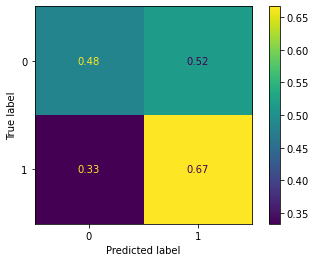

In [ ]:
plot_confusion_matrix(lr, x_val, y_val, normalize='true')
plt.show()

##### Output transformation
Подготовка данных для рексисовского аутпута:

In [ ]:
df_val_reordered_pivot = pd.read_pickle('data/df_val_reordered_pivot.pkl')
df_val_reordered_pivot.head()

,user_id,product_id
0,1,"[196, 46149, 39657, 38928, 25133, 10258, 35951..."
1,2,"[24852, 16589, 1559, 19156, 18523, 22825, 2741..."
2,3,"[39190, 47766, 21903, 43961, 17668]"
3,4,"[22199, 25146]"
4,5,"[27344, 24535, 43693, 40706, 16168, 21413, 139..."


In [ ]:
val_short = val[['user_id', 'product_id']]
val_short['lr_proba'] = y_val_pred_proba
val_short = val_short.sort_values(by=['user_id', 'lr_proba'], ascending=False)
val_short.reset_index(drop=True, inplace=True)
val_short.head()

<ipython-input-41-202406dddd4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_short['lr_proba'] = y_val_pred_proba


,user_id,product_id,lr_proba
0,206209,33351,0.593699
1,206209,37654,0.582545
2,206209,40396,0.580446
3,206209,40310,0.578394
4,206209,43961,0.577096


In [ ]:
user_ids = val_short['user_id'].unique()
val_short['top_10'] = 0

for i in user_ids:
    indexes = val_short[val_short['user_id'] == i][0:10].index
    val_short.loc[indexes, 'top_10'] = 1
    
val_short.head()

,user_id,product_id,lr_proba,top_10
0,206209,33351,0.593699,1
1,206209,37654,0.582545,1
2,206209,40396,0.580446,1
3,206209,40310,0.578394,1
4,206209,43961,0.577096,1


In [ ]:
val_short = val_short.rename({'top_10':'top_10_lr'}, axis=1)
val_short.to_pickle('data/val_short_lr.pkl')

In [ ]:
val_short_top = val_short[val_short['top_10'] == 1]
val_short_top_pivot = val_short_top.pivot_table(index='user_id', values=['product_id'], 
                                            aggfunc={'product_id': lambda x: list(x)}).reset_index()
val_short_top_pivot.head()

,user_id,product_id
0,150001,"[4942, 21903, 27801, 28829, 4656, 7751, 25146,..."
1,150002,"[39581, 29780, 29734, 47114, 35221, 2627, 3460..."
2,150003,"[31759, 19660]"
3,150004,"[21903, 13829, 37250, 5991, 14540, 34358, 3526..."
4,150005,"[43841, 45896, 37654, 21903, 48527, 7350, 3461..."


In [ ]:
val_short_top_pivot = val_short_top_pivot.merge(df_val_reordered_pivot, on='user_id', how='left')
val_short_top_pivot = val_short_top_pivot.rename({'product_id_y':'true_val_label', 'product_id_x':'lr_recommend'}, axis=1)
val_short_top_pivot.head()

,user_id,lr_recommend,true_val_label
0,150001,"[4942, 21903, 27801, 28829, 4656, 7751, 25146,...",[35954]
1,150002,"[39581, 29780, 29734, 47114, 35221, 2627, 3460...","[2717, 41682, 30353, 3389]"
2,150003,"[31759, 19660]",[19660]
3,150004,"[21903, 13829, 37250, 5991, 14540, 34358, 3526...","[21903, 8021, 10880]"
4,150005,"[43841, 45896, 37654, 21903, 48527, 7350, 3461...","[44785, 30574, 1752, 13448, 7930, 3590, 1521, ..."


In [ ]:
val_short_top_pivot.to_pickle('data/val_short_top_pivot_lr.pkl')

In [ ]:
print_metrics(val_short_top_pivot['true_val_label'], val_short_top_pivot['lr_recommend'], 10)

      metric     value
0  HitRate@k  0.733619
1      MAP@k  0.300186
2     NDCG@k  0.217685


#### Данные для итогового предсказания

In [11]:
lr = LogisticRegression()
lr.fit(x_train_rus_2, y_train_rus_2)

C:\Users\Elizaveta_Masharina\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [17]:
pickle.dump(lr, open("models/lr_2.pickle.dat", "wb"))

In [12]:
y_train_pred = lr.predict(x_train_2)
y_train_pred_proba = lr.predict_proba(x_train_2)[:, 1]

In [13]:
print('accuracy_score:', accuracy_score(y_train_2, y_train_pred), 
      '\nrecall_score:', recall_score(y_train_2, y_train_pred), 
      '\nprecision_score:', precision_score(y_train_2, y_train_pred))

accuracy_score: 0.510754486380122 
recall_score: 0.6581628959938448 
precision_score: 0.12842071653361994


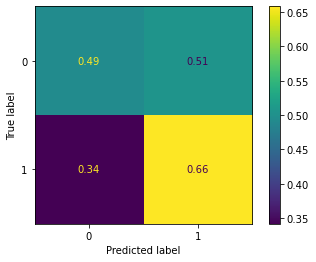

In [14]:
plot_confusion_matrix(lr, x_train_2, y_train_2, normalize='true')
plt.show()

In [8]:
loaded_lr = pickle.load(open("models/lr_2.pickle.dat", "rb"))

In [9]:
y_test_pred = loaded_lr.predict(x_train_val)
y_test_pred_proba = loaded_lr.predict_proba(x_train_val)[:, 1]

In [10]:
print('accuracy_score:', accuracy_score(y_train_val, y_test_pred), 
      '\nrecall_score:', recall_score(y_train_val, y_test_pred), 
      '\nprecision_score:', precision_score(y_train_val, y_test_pred))

accuracy_score: 0.12292131972833817 
recall_score: 0.9797062972127116 
precision_score: 0.10114241982543987


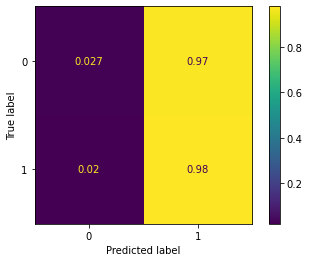

In [11]:
plot_confusion_matrix(loaded_lr, x_train_val, y_train_val, normalize='true')
plt.show()

##### Output transformation
Подготовка данных для рексисовского аутпута:

In [13]:
df_test_reordered_pivot = pd.read_pickle('data/df_test_reordered_pivot.pkl')
df_test_reordered_pivot.head()

,user_id,product_id
0,1,"[196, 25133, 38928, 26405, 39657, 10258, 13032..."
1,2,"[22963, 7963, 16589, 32792, 41787, 22825, 1364..."
2,3,"[39190, 18599, 23650, 21903, 47766, 24810]"
3,4,"[26576, 25623, 21573]"
4,5,"[15349, 19057, 16185, 21413, 20843, 20114, 482..."


In [15]:
df_train_val.head()

,user_id,product_id,rating,rating_sum,rating_norm,product_and_rating,0,1_product,2_product,3_product,...,56_user,57_user,58_user,59_user,60_user,61_user,62_user,63_user,64_user,reordered
0,1,196,10,59,0.169492,196:0.1694915254237288,196.0,0.001409,0.005207,0.002497,...,-0.003182,-0.001425,-0.000811,-0.001972,-0.005607,0.000983,0.000224,0.004254,-0.004842,1.0
1,1,10258,9,59,0.152542,10258:0.15254237288135594,10258.0,0.005821,0.007413,0.000061,...,-0.003182,-0.001425,-0.000811,-0.001972,-0.005607,0.000983,0.000224,0.004254,-0.004842,1.0
2,1,10326,1,59,0.016949,10326:0.01694915254237288,10326.0,0.002304,0.003594,0.000376,...,-0.003182,-0.001425,-0.000811,-0.001972,-0.005607,0.000983,0.000224,0.004254,-0.004842,0.0
3,1,12427,10,59,0.169492,12427:0.1694915254237288,12427.0,0.005686,0.012542,-0.002346,...,-0.003182,-0.001425,-0.000811,-0.001972,-0.005607,0.000983,0.000224,0.004254,-0.004842,0.0
4,1,13032,3,59,0.050847,13032:0.05084745762711865,13032.0,0.004938,0.007218,0.002687,...,-0.003182,-0.001425,-0.000811,-0.001972,-0.005607,0.000983,0.000224,0.004254,-0.004842,1.0


In [51]:
df_train_val_short = df_train_val[['user_id', 'product_id']]
df_train_val_short['lr_proba'] = y_test_pred_proba
df_train_val_short = df_train_val_short.sort_values(by=['user_id', 'lr_proba'], ascending=False)
df_train_val_short.reset_index(drop=True, inplace=True)
df_train_val_short.head()

<ipython-input-51-509e0905c4f1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_val_short['lr_proba'] = y_test_pred_proba


,user_id,product_id,lr_proba
0,206209,48370,0.836932
1,206209,40534,0.835050
2,206209,36056,0.800609
3,206209,38167,0.708293
4,206209,6825,0.698693


In [64]:
df_train_val_short_top_pivot = df_train_val_short.pivot_table(index='user_id', values=['product_id'], 
                                            aggfunc={'product_id': lambda x: list(x)[:10]}).reset_index()
df_train_val_short_top_pivot = df_train_val_short_top_pivot.rename({'product_id':'lr_recommend'}, axis=1)
df_train_val_short_top_pivot.head()

,user_id,lr_recommend
0,1,"[25133, 39657, 35951, 26088, 12427, 38928, 304..."
1,2,"[32052, 36287, 35917, 32139, 27413, 5869, 3327..."
2,3,"[39922, 39190, 38596, 32402, 24810, 23650, 151..."
3,4,"[43704, 42329, 7160, 35469, 22199, 37646, 1200..."
4,5,"[31717, 6808, 24535, 15349, 40706, 18761, 3376..."


In [65]:
df_train_val_short_top_pivot = df_train_val_short_top_pivot.merge(df_test_reordered_pivot, on='user_id', how='left')
df_train_val_short_top_pivot = df_train_val_short_top_pivot.rename({'product_id':'true_test_label'}, axis=1)
df_train_val_short_top_pivot.head()

,user_id,lr_recommend,true_test_label
0,1,"[25133, 39657, 35951, 26088, 12427, 38928, 304...","[196, 25133, 38928, 26405, 39657, 10258, 13032..."
1,2,"[32052, 36287, 35917, 32139, 27413, 5869, 3327...","[22963, 7963, 16589, 32792, 41787, 22825, 1364..."
2,3,"[39922, 39190, 38596, 32402, 24810, 23650, 151...","[39190, 18599, 23650, 21903, 47766, 24810]"
3,4,"[43704, 42329, 7160, 35469, 22199, 37646, 1200...","[26576, 25623, 21573]"
4,5,"[31717, 6808, 24535, 15349, 40706, 18761, 3376...","[15349, 19057, 16185, 21413, 20843, 20114, 482..."


In [66]:
df_train_val_short_top_pivot.to_pickle('data/df_train_val_short_top_pivot.pkl')

In [67]:
print_metrics(df_train_val_short_top_pivot['true_test_label'], df_train_val_short_top_pivot['lr_recommend'], 10)

      metric     value
0  HitRate@k  0.622611
1      MAP@k  0.230476
2     NDCG@k  0.161520


### XGBClassifier
Стандартные параметры:

#### Данные для тренировки

In [ ]:
%%time
xgb = XGBClassifier(random_state=42)
xgb.fit(x_train_rus, y_train_rus)

C:\Users\Elizaveta_Masharina\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:55:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 15min 5s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
y_val_pred = xgb.predict(x_val)
y_val_pred_proba = xgb.predict_proba(x_val)[:, 1]

In [ ]:
print('accuracy_score:', accuracy_score(y_val, y_val_pred), 
      '\nrecall_score:', recall_score(y_val, y_val_pred), 
      '\nprecision_score:', precision_score(y_val, y_val_pred))

accuracy_score: 0.6470014853888105 
recall_score: 0.6260020100021536 
precision_score: 0.1681150852142425


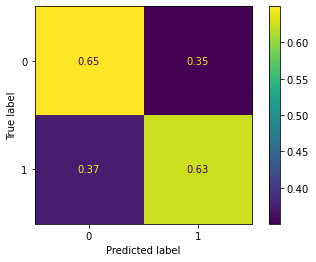

In [ ]:
plot_confusion_matrix(xgb, x_val, y_val, normalize='true')
plt.show()

##### Output transformation
Подготовка данных для рексисовского аутпута:

In [ ]:
df_val_reordered_pivot = pd.read_pickle('data/df_val_reordered_pivot.pkl')
df_val_reordered_pivot.head()

,user_id,product_id
0,1,"[196, 46149, 39657, 38928, 25133, 10258, 35951..."
1,2,"[24852, 16589, 1559, 19156, 18523, 22825, 2741..."
2,3,"[39190, 47766, 21903, 43961, 17668]"
3,4,"[22199, 25146]"
4,5,"[27344, 24535, 43693, 40706, 16168, 21413, 139..."


In [ ]:
val_short = pd.read_pickle('data/val_short_lr.pkl')
val_short.head()

,user_id,product_id,lr_proba,top_10_lr
0,206209,33351,0.593699,1
1,206209,37654,0.582545,1
2,206209,40396,0.580446,1
3,206209,40310,0.578394,1
4,206209,43961,0.577096,1


In [ ]:
val_short['xgb_proba'] = y_val_pred_proba
val_short = val_short.sort_values(by=['user_id', 'xgb_proba'], ascending=False)
val_short.reset_index(drop=True, inplace=True)
val_short.head()

,user_id,product_id,lr_proba,top_10_lr,xgb_proba
0,206209,40396,0.580446,1,0.784942
1,206209,37654,0.582545,1,0.585072
2,206209,40310,0.578394,1,0.573053
3,206209,23594,0.500867,0,0.557015
4,206209,43961,0.577096,1,0.539732


In [ ]:
user_ids = val_short['user_id'].unique()
val_short['top_10_xgb'] = 0

for i in user_ids:
    indexes = val_short[val_short['user_id'] == i][0:10].index
    val_short.loc[indexes, 'top_10_xgb'] = 1
    
val_short.head()

,user_id,product_id,lr_proba,top_10_lr,xgb_proba,top_10_xgb
0,206209,40396,0.580446,1,0.784942,1
1,206209,37654,0.582545,1,0.585072,1
2,206209,40310,0.578394,1,0.573053,1
3,206209,23594,0.500867,0,0.557015,1
4,206209,43961,0.577096,1,0.539732,1


In [ ]:
val_short.to_pickle('data/val_short_xgb.pkl')

In [ ]:
val_short_top = val_short[val_short['top_10_xgb'] == 1]
val_short_top_pivot = val_short_top.pivot_table(index='user_id', values=['product_id'], 
                                            aggfunc={'product_id': lambda x: list(x)}).reset_index()
val_short_top_pivot.head()

,user_id,product_id
0,150001,"[30428, 11716, 5385, 34449, 41178, 15012, 3504..."
1,150002,"[10957, 41682, 37047, 2974, 34600, 7693, 48367..."
2,150003,"[31759, 19660]"
3,150004,"[14540, 5991, 34358, 35264, 21903, 13829, 4451..."
4,150005,"[47194, 46764, 6244, 40544, 26318, 25854, 2033..."


In [ ]:
val_short_top_pivot = val_short_top_pivot.merge(df_val_reordered_pivot, on='user_id', how='left')
val_short_top_pivot = val_short_top_pivot.rename({'product_id_y':'true_val_label', 'product_id_x':'xgb_recommend'}, axis=1)
val_short_top_pivot.head()

,user_id,xgb_recommend,true_val_label
0,150001,"[30428, 11716, 5385, 34449, 41178, 15012, 3504...",[35954]
1,150002,"[10957, 41682, 37047, 2974, 34600, 7693, 48367...","[2717, 41682, 30353, 3389]"
2,150003,"[31759, 19660]",[19660]
3,150004,"[14540, 5991, 34358, 35264, 21903, 13829, 4451...","[21903, 8021, 10880]"
4,150005,"[47194, 46764, 6244, 40544, 26318, 25854, 2033...","[44785, 30574, 1752, 13448, 7930, 3590, 1521, ..."


In [ ]:
val_short_top_pivot.to_pickle('data/val_short_top_pivot_xgb.pkl')

In [ ]:
print_metrics(val_short_top_pivot['true_val_label'], val_short_top_pivot['xgb_recommend'], 10)

      metric     value
0  HitRate@k  0.662581
1      MAP@k  0.264669
2     NDCG@k  0.183918


### XGBClassifier
Подбор параметров:

#### Данные для тренировки

In [ ]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [ ]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [ ]:
%%time

def objective(space):
    params = {
        'colsample_bytree': '{:.3f}'.format(space['colsample_bytree']),
        'learning_rate': '{:.3f}'.format(space['learning_rate']),
        'alpha' : '{:.3f}'.format(space['alpha']),
        'n_estimators': space['n_estimators']
    }
    
    clf = XGBClassifier(
        objective ='binary:logistic',
        random_state=42,
        **params
    )
    
    score = cross_val_score(clf, x_train_rus, y_train_rus, scoring='roc_auc', cv=skf).mean()
    print("AUC {:.3f} params {}".format(score, params))
    return {'loss':1 - score, 'status': STATUS_OK }

space = {
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'learning_rate': hp.uniform('learning_rate', 0, 1),
    'alpha': hp.uniform('alpha', 0, 10),
    'n_estimators': hp.choice('n_estimators', [100, 500, 1000])
    }

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=3)

  0%|                                                                                | 0/3 [00:00<?, ?trial/s, best loss=?]

C:\Users\Elizaveta_Masharina\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[18:26:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  0%|                                                                                | 0/3 [00:08<?, ?trial/s, best loss=?]

C:\Users\Elizaveta_Masharina\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[18:29:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  0%|                                                                                | 0/3 [03:24<?, ?trial/s, best loss=?]

C:\Users\Elizaveta_Masharina\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[18:33:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC 0.694 params {'colsample_bytree': '0.302', 'learning_rate': '0.368', 'alpha': '0.183', 'n_estimators': 100}            
 33%|██████████████████                                    | 1/3 [09:49<19:38, 589.16s/trial, best loss: 0.305564698157862]

C:\Users\Elizaveta_Masharina\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[18:36:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 33%|██████████████████                                    | 1/3 [09:58<19:38, 589.16s/trial, best loss: 0.305564698157862]

C:\Users\Elizaveta_Masharina\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[19:05:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 33%|██████████████████                                    | 1/3 [39:29<19:38, 589.16s/trial, best loss: 0.305564698157862]

C:\Users\Elizaveta_Masharina\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[19:35:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC 0.697 params {'colsample_bytree': '0.607', 'learning_rate': '0.869', 'alpha': '1.101', 'n_estimators': 500}            
 67%|█████████████████████████████████▎                | 2/3 [1:36:52<32:59, 1979.45s/trial, best loss: 0.3025659644628135]

C:\Users\Elizaveta_Masharina\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[20:03:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 67%|█████████████████████████████████▎                | 2/3 [1:37:04<32:59, 1979.45s/trial, best loss: 0.3025659644628135]

C:\Users\Elizaveta_Masharina\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[20:12:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 67%|█████████████████████████████████▎                | 2/3 [1:45:52<32:59, 1979.45s/trial, best loss: 0.3025659644628135]

C:\Users\Elizaveta_Masharina\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[20:21:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC 0.688 params {'colsample_bytree': '0.967', 'learning_rate': '0.937', 'alpha': '0.640', 'n_estimators': 100}            
100%|██████████████████████████████████████████████████| 3/3 [2:05:03<00:00, 2501.01s/trial, best loss: 0.3025659644628135]
Wall time: 2h 5min 3s


In [ ]:
best

{'alpha': 1.10070833548367,
 'colsample_bytree': 0.6068347703263106,
 'learning_rate': 0.8691767919431599,
 'n_estimators': 1}

#### Данные для итогового предсказания

In [11]:
# best_xg_clf = XGBClassifier(objective ='binary:logistic', 
#                             alpha=best['alpha'],
#                             colsample_bytree = best['colsample_bytree'],
#                             learning_rate=best['learning_rate'],
#                             n_estimators=500,
#                             random_state=42)                   

best_xg_clf = XGBClassifier(objective = 'binary:logistic', 
                            alpha = 1.10070833548367,
                            colsample_bytree = 0.6068347703263106,
                            learning_rate = 0.8691767919431599,
                            n_estimators = 500,
                            random_state = 42)                   

In [12]:
best_xg_clf.fit(x_train_rus_2, y_train_rus_2)

C:\Users\Elizaveta_Masharina\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:14:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(alpha=1.10070833548367, base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.6068347703263106, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.8691767919431599, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=1.10070837, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [13]:
pickle.dump(best_xg_clf, open("models/best_xg_clf_2.pickle.dat", "wb"))

In [14]:
y_train_pred = best_xg_clf.predict(x_train_2)
y_train_pred_proba = best_xg_clf.predict_proba(x_train_2)[:, 1]

In [15]:
print('accuracy_score:', accuracy_score(y_train_2, y_train_pred), 
      '\nrecall_score:', recall_score(y_train_2, y_train_pred), 
      '\nprecision_score:', precision_score(y_train_2, y_train_pred))

accuracy_score: 0.6661485273783586 
recall_score: 0.7205377976841614 
precision_score: 0.193565182585


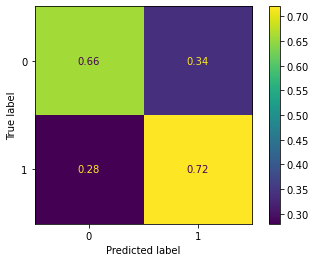

In [16]:
plot_confusion_matrix(best_xg_clf, x_train_2, y_train_2, normalize='true')
plt.show()

In [11]:
loaded_xgb = pickle.load(open("models/best_xg_clf_2.pickle.dat", "rb"))

In [12]:
y_test_pred = loaded_xgb.predict(x_train_val)
y_test_pred_proba = loaded_xgb.predict_proba(x_train_val)[:, 1]

In [13]:
print('accuracy_score:', accuracy_score(y_train_val, y_test_pred), 
      '\nrecall_score:', recall_score(y_train_val, y_test_pred), 
      '\nprecision_score:', precision_score(y_train_val, y_test_pred))

accuracy_score: 0.2598609678000665 
recall_score: 0.8261109108657534 
precision_score: 0.10304933789996223


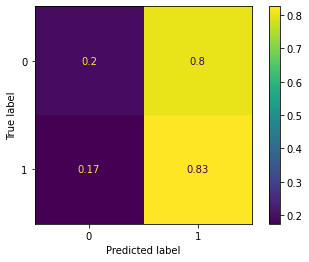

In [14]:
plot_confusion_matrix(loaded_xgb, x_train_val, y_train_val, normalize='true')
plt.show()

##### Output transformation
Подготовка данных для рексисовского аутпута:

In [15]:
df_test_reordered_pivot = pd.read_pickle('data/df_train_val_short_top_pivot.pkl')
df_test_reordered_pivot.head()

,user_id,lr_recommend,true_test_label
0,1,"[25133, 39657, 35951, 26088, 12427, 38928, 304...","[196, 25133, 38928, 26405, 39657, 10258, 13032..."
1,2,"[32052, 36287, 35917, 32139, 27413, 5869, 3327...","[22963, 7963, 16589, 32792, 41787, 22825, 1364..."
2,3,"[39922, 39190, 38596, 32402, 24810, 23650, 151...","[39190, 18599, 23650, 21903, 47766, 24810]"
3,4,"[43704, 42329, 7160, 35469, 22199, 37646, 1200...","[26576, 25623, 21573]"
4,5,"[31717, 6808, 24535, 15349, 40706, 18761, 3376...","[15349, 19057, 16185, 21413, 20843, 20114, 482..."


In [16]:
df_train_val_short = df_train_val[['user_id', 'product_id']]
df_train_val_short['xgb_proba'] = y_test_pred_proba
df_train_val_short = df_train_val_short.sort_values(by=['user_id', 'xgb_proba'], ascending=False)
df_train_val_short.reset_index(drop=True, inplace=True)
df_train_val_short.head()

<ipython-input-16-6a76aff187e2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_val_short['xgb_proba'] = y_test_pred_proba


,user_id,product_id,xgb_proba
0,206209,14727,0.996920
1,206209,23594,0.995899
2,206209,40310,0.994015
3,206209,20842,0.992870
4,206209,2295,0.989550


In [19]:
df_train_val_short_top_pivot = df_train_val_short.pivot_table(index='user_id', values=['product_id'], 
                                            aggfunc={'product_id': lambda x: list(x)[:10]}).reset_index()
df_train_val_short_top_pivot = df_train_val_short_top_pivot.rename({'product_id':'xgb_recommend'}, axis=1)
df_train_val_short_top_pivot.head()

,user_id,xgb_recommend
0,1,"[13176, 14084, 25133, 39657, 12427, 26405, 196..."
1,2,"[5322, 21227, 14553, 32052, 16589, 19057, 3468..."
2,3,"[23650, 24010, 18599, 21137, 17668, 32402, 167..."
3,4,"[7350, 19057, 36606, 37646, 25146, 35469, 4370..."
4,5,"[21616, 15349, 31717, 8518, 21413, 18761, 2247..."


In [21]:
df_train_val_short_top_pivot = df_train_val_short_top_pivot.merge(df_test_reordered_pivot, on='user_id', how='left')
df_train_val_short_top_pivot.head()

,user_id,xgb_recommend,lr_recommend,true_test_label
0,1,"[13176, 14084, 25133, 39657, 12427, 26405, 196...","[25133, 39657, 35951, 26088, 12427, 38928, 304...","[196, 25133, 38928, 26405, 39657, 10258, 13032..."
1,2,"[5322, 21227, 14553, 32052, 16589, 19057, 3468...","[32052, 36287, 35917, 32139, 27413, 5869, 3327...","[22963, 7963, 16589, 32792, 41787, 22825, 1364..."
2,3,"[23650, 24010, 18599, 21137, 17668, 32402, 167...","[39922, 39190, 38596, 32402, 24810, 23650, 151...","[39190, 18599, 23650, 21903, 47766, 24810]"
3,4,"[7350, 19057, 36606, 37646, 25146, 35469, 4370...","[43704, 42329, 7160, 35469, 22199, 37646, 1200...","[26576, 25623, 21573]"
4,5,"[21616, 15349, 31717, 8518, 21413, 18761, 2247...","[31717, 6808, 24535, 15349, 40706, 18761, 3376...","[15349, 19057, 16185, 21413, 20843, 20114, 482..."


In [22]:
df_train_val_short_top_pivot.to_pickle('data/df_train_val_short_top_pivot_lr_xgb.pkl')

In [23]:
print_metrics(df_train_val_short_top_pivot['true_test_label'], df_train_val_short_top_pivot['xgb_recommend'], 10)

      metric     value
0  HitRate@k  0.671629
1      MAP@k  0.262091
2     NDCG@k  0.182692


In [24]:
print_metrics(df_train_val_short_top_pivot['true_test_label'], df_train_val_short_top_pivot['lr_recommend'], 10)

      metric     value
0  HitRate@k  0.622611
1      MAP@k  0.230476
2     NDCG@k  0.161520
